In [1]:
import os
import scipy.misc
import numpy as np
import json

# from model import DCGAN
from model_steer2_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
FLAGS = flags.FLAGS

In [ ]:
def main(_):
  pp.pprint(flags.FLAGS.__flags)
  
  # expand user name and environment variables
  FLAGS.data_dir = expand_path(FLAGS.data_dir)
  FLAGS.out_dir = expand_path(FLAGS.out_dir)
  FLAGS.out_name = expand_path(FLAGS.out_name)
  FLAGS.checkpoint_dir = expand_path(FLAGS.checkpoint_dir)
  FLAGS.sample_dir = expand_path(FLAGS.sample_dir)

  print('FLAGS.dataset:', FLAGS.dataset)  
  print('FLAGS.output_height', FLAGS.output_height)  
  print('flags.train', FLAGS.train)

  if FLAGS.output_height is None: FLAGS.output_height = FLAGS.input_height
  if FLAGS.input_width is None: FLAGS.input_width = FLAGS.input_height
  if FLAGS.output_width is None: FLAGS.output_width = FLAGS.output_height

  # output folders
  if FLAGS.out_name == "":
      FLAGS.out_name = '{} - {} - {}'.format(timestamp(), FLAGS.data_dir.split('/')[-1], FLAGS.dataset) # penultimate folder of path
      if FLAGS.train:
        FLAGS.out_name += ' - x{}.z{}.{}.y{}.b{}'.format(FLAGS.input_width, FLAGS.z_dim, FLAGS.z_dist, FLAGS.output_width, FLAGS.batch_size)

  FLAGS.out_dir = os.path.join(FLAGS.out_dir, FLAGS.out_name)
  FLAGS.checkpoint_dir = os.path.join(FLAGS.out_dir, FLAGS.checkpoint_dir)
  FLAGS.sample_dir = os.path.join(FLAGS.out_dir, FLAGS.sample_dir)

  if not os.path.exists(FLAGS.checkpoint_dir): os.makedirs(FLAGS.checkpoint_dir)
  if not os.path.exists(FLAGS.sample_dir): os.makedirs(FLAGS.sample_dir)

  with open(os.path.join(FLAGS.out_dir, 'FLAGS.json'), 'w') as f:
    flags_dict = {k:FLAGS[k].value for k in FLAGS}
    json.dump(flags_dict, f, indent=4, sort_keys=True, ensure_ascii=False)
  

  #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
  run_config = tf.ConfigProto()
  run_config.gpu_options.allow_growth=True

  with tf.Session(config=run_config) as sess:
    if FLAGS.dataset == 'mnist':
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          y_dim=10,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)
    else:
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)

    show_all_variables()

    if FLAGS.train:
      dcgan.train(FLAGS)
    else:
      load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
      if not load_success:
        raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)


    # to_json("./web/js/layers.js", [dcgan.h0_w, dcgan.h0_b, dcgan.g_bn0],
    #                 [dcgan.h1_w, dcgan.h1_b, dcgan.g_bn1],
    #                 [dcgan.h2_w, dcgan.h2_b, dcgan.g_bn2],
    #                 [dcgan.h3_w, dcgan.h3_b, dcgan.g_bn3],
    #                 [dcgan.h4_w, dcgan.h4_b, None])

    # Below is codes for visualization
      if FLAGS.export:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'export_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=True, frozen=False)

      if FLAGS.freeze:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'frozen_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=False, frozen=True)

      if FLAGS.visualize:
        OPTION = 1
        visualize(sess, dcgan, FLAGS, OPTION, FLAGS.sample_dir)

# if __name__ == '__main__':
#   tf.app.run()

{'G_img_sum': <absl.flags._flag.BooleanFlag object at 0x7f7418401b70>,
 'batch_size': <absl.flags._flag.Flag object at 0x7f74f0b4d6a0>,
 'beta1': <absl.flags._flag.Flag object at 0x7f74f0b4d5f8>,
 'checkpoint_dir': <absl.flags._flag.Flag object at 0x7f7418401470>,
 'ckpt_freq': <absl.flags._flag.Flag object at 0x7f7418401898>,
 'crop': <absl.flags._flag.BooleanFlag object at 0x7f7418401668>,
 'data_dir': <absl.flags._flag.Flag object at 0x7f74184012b0>,
 'dataset': <absl.flags._flag.Flag object at 0x7f7418401128>,
 'epoch': <absl.flags._flag.Flag object at 0x7f75082b99e8>,
 'export': <absl.flags._flag.BooleanFlag object at 0x7f7418401780>,
 'freeze': <absl.flags._flag.BooleanFlag object at 0x7f74184017f0>,
 'h': <tensorflow.python.platform.app._HelpFlag object at 0x7f75095eb710>,
 'help': <tensorflow.python.platform.app._HelpFlag object at 0x7f75095eb710>,
 'helpfull': <tensorflow.python.platform.app._HelpfullFlag object at 0x7f75095eb748>,
 'helpshort': <tensorflow.python.platform.app

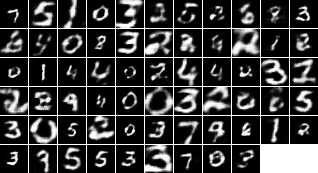

Target mask:


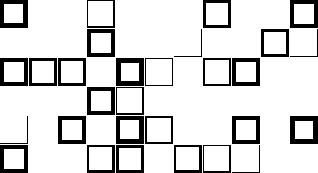

[     400 Epoch:[ 0/25] [   0/1093] time: 5.7102, d_loss: 1.51989079, g_loss: 2.28418446, walk_loss: 2.28418446
[Sample] d_loss: 1.9255527257919312, g_loss: 2.3568432331085205, w_loss: 2.3568432331085205
Target image:


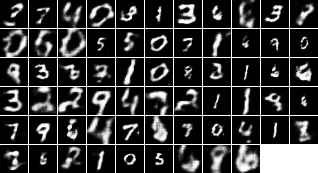

Target mask:


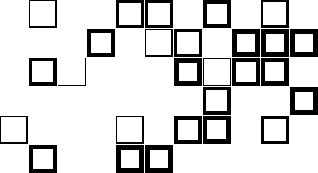

[     401 Epoch:[ 0/25] [   1/1093] time: 10.3295, d_loss: 1.52478337, g_loss: 2.23528004, walk_loss: 2.23528028
Target image:


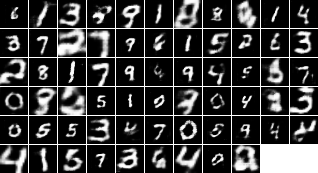

Target mask:


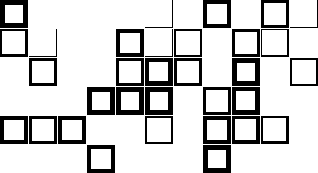

[     402 Epoch:[ 0/25] [   2/1093] time: 10.6295, d_loss: 1.50981569, g_loss: 2.26863074, walk_loss: 2.26863074
Target image:


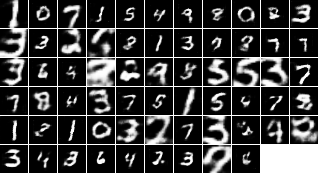

Target mask:


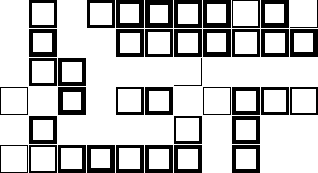

[     403 Epoch:[ 0/25] [   3/1093] time: 10.9045, d_loss: 1.48661375, g_loss: 2.25245738, walk_loss: 2.25245738
Target image:


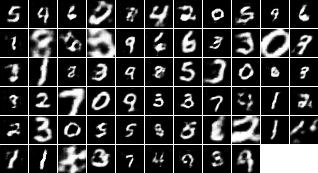

Target mask:


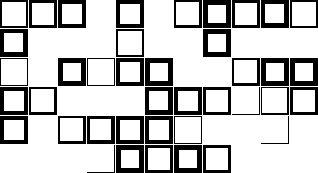

[     404 Epoch:[ 0/25] [   4/1093] time: 11.2029, d_loss: 1.51337874, g_loss: 2.22995853, walk_loss: 2.22995853
Target image:


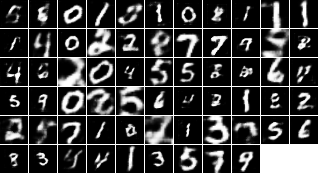

Target mask:


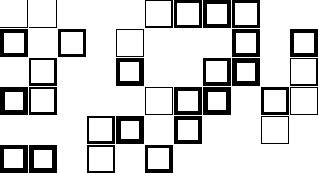

[     405 Epoch:[ 0/25] [   5/1093] time: 11.4551, d_loss: 1.49566352, g_loss: 2.19346333, walk_loss: 2.19346333
Target image:


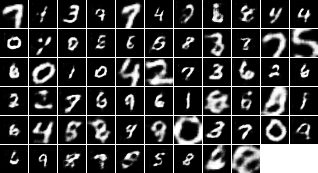

Target mask:


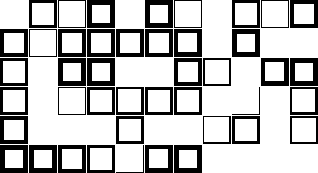

[     406 Epoch:[ 0/25] [   6/1093] time: 11.7467, d_loss: 1.50544000, g_loss: 2.22197270, walk_loss: 2.22197270
Target image:


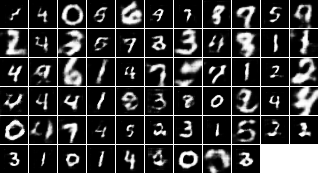

Target mask:


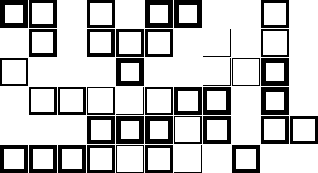

[     407 Epoch:[ 0/25] [   7/1093] time: 12.0403, d_loss: 1.49705625, g_loss: 2.18541694, walk_loss: 2.18541694
Target image:


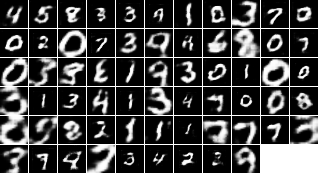

Target mask:


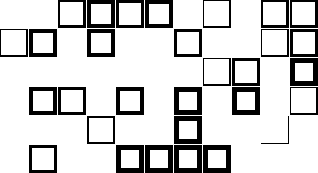

[     408 Epoch:[ 0/25] [   8/1093] time: 12.2950, d_loss: 1.49808824, g_loss: 2.23340082, walk_loss: 2.23340082
Target image:


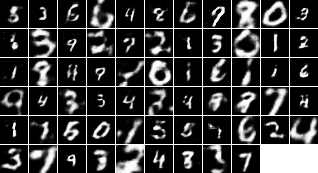

Target mask:


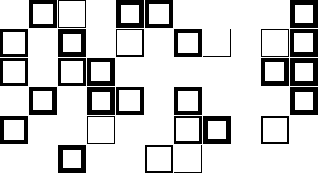

[     409 Epoch:[ 0/25] [   9/1093] time: 12.5832, d_loss: 1.49673200, g_loss: 2.20686245, walk_loss: 2.20686269
Target image:


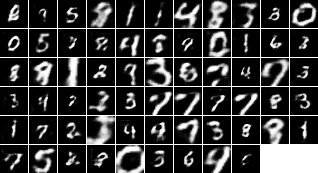

Target mask:


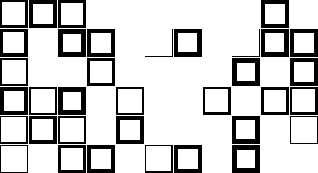

[     410 Epoch:[ 0/25] [  10/1093] time: 12.8184, d_loss: 1.47166121, g_loss: 2.23496485, walk_loss: 2.23496485
Target image:


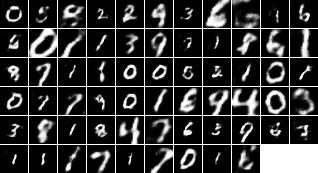

Target mask:


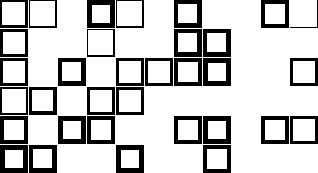

[     411 Epoch:[ 0/25] [  11/1093] time: 13.0637, d_loss: 1.49368143, g_loss: 2.22826052, walk_loss: 2.22826052
Target image:


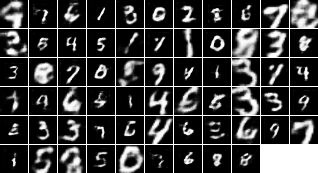

Target mask:


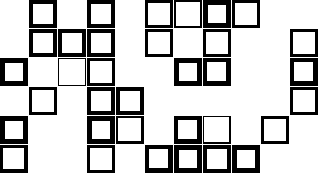

[     412 Epoch:[ 0/25] [  12/1093] time: 13.3113, d_loss: 1.49586999, g_loss: 2.22604465, walk_loss: 2.22604465
Target image:


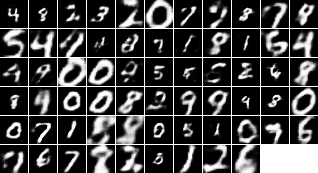

Target mask:


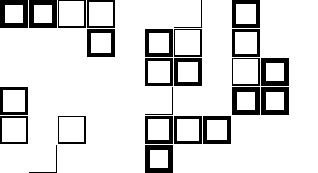

[     413 Epoch:[ 0/25] [  13/1093] time: 13.6025, d_loss: 1.49903440, g_loss: 2.24466372, walk_loss: 2.24466372
Target image:


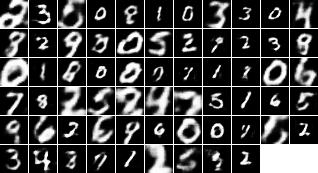

Target mask:


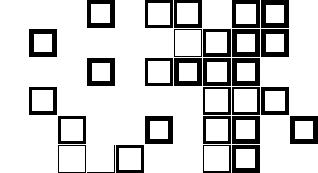

[     414 Epoch:[ 0/25] [  14/1093] time: 13.9023, d_loss: 1.51479459, g_loss: 2.22961831, walk_loss: 2.22961831
Target image:


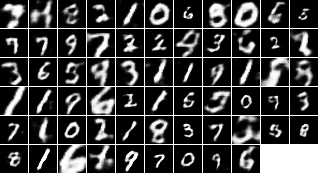

Target mask:


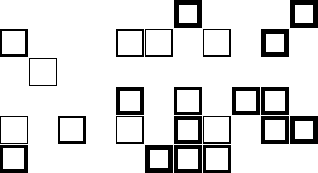

[     415 Epoch:[ 0/25] [  15/1093] time: 14.1930, d_loss: 1.52243292, g_loss: 2.19878125, walk_loss: 2.19878125
Target image:


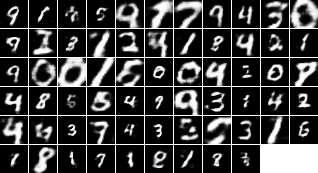

Target mask:


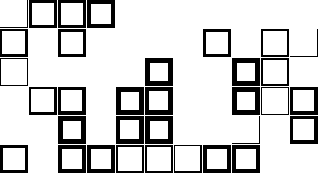

[     416 Epoch:[ 0/25] [  16/1093] time: 14.4746, d_loss: 1.51256609, g_loss: 2.23685551, walk_loss: 2.23685551
Target image:


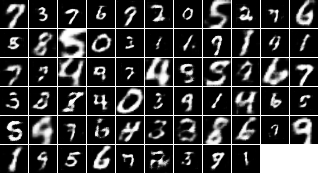

Target mask:


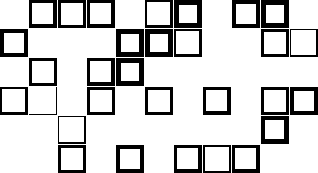

[     417 Epoch:[ 0/25] [  17/1093] time: 14.7265, d_loss: 1.50632703, g_loss: 2.21176744, walk_loss: 2.21176744
Target image:


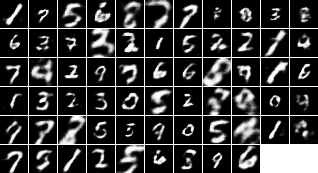

Target mask:


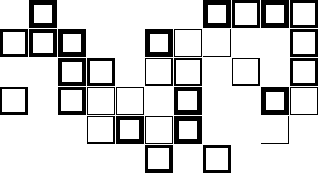

[     418 Epoch:[ 0/25] [  18/1093] time: 14.9796, d_loss: 1.51128292, g_loss: 2.21094251, walk_loss: 2.21094251
Target image:


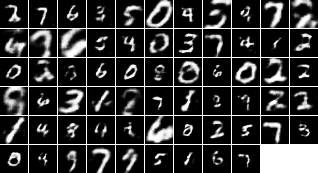

Target mask:


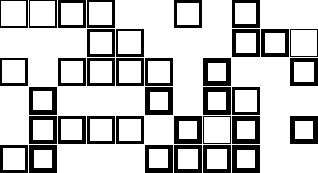

[     419 Epoch:[ 0/25] [  19/1093] time: 15.2440, d_loss: 1.50519657, g_loss: 2.21550417, walk_loss: 2.21550417
Target image:


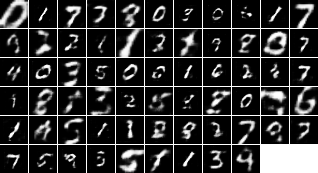

Target mask:


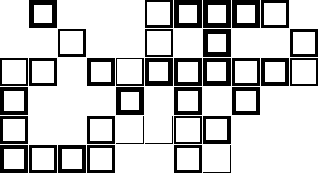

[     420 Epoch:[ 0/25] [  20/1093] time: 15.4886, d_loss: 1.50016129, g_loss: 2.22234941, walk_loss: 2.22234941
Target image:


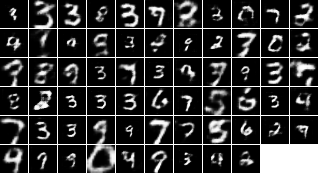

Target mask:


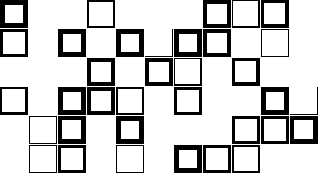

[     421 Epoch:[ 0/25] [  21/1093] time: 15.7305, d_loss: 1.51097536, g_loss: 2.24854088, walk_loss: 2.24854088
Target image:


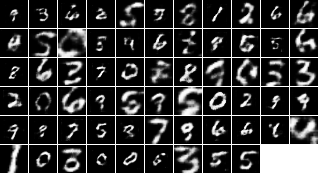

Target mask:


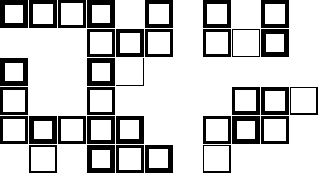

[     422 Epoch:[ 0/25] [  22/1093] time: 16.0168, d_loss: 1.50972009, g_loss: 2.25825715, walk_loss: 2.25825715
Target image:


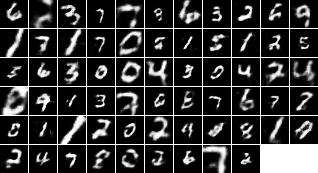

Target mask:


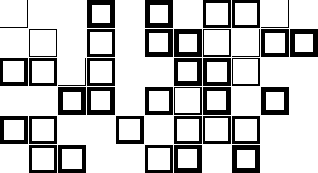

[     423 Epoch:[ 0/25] [  23/1093] time: 16.3067, d_loss: 1.50679278, g_loss: 2.21557355, walk_loss: 2.21557355
Target image:


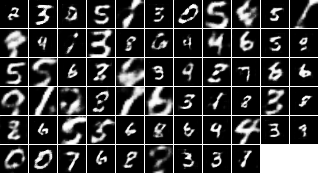

Target mask:


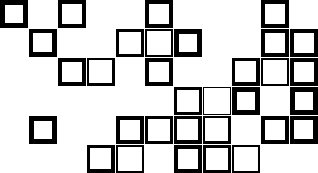

[     424 Epoch:[ 0/25] [  24/1093] time: 16.5738, d_loss: 1.50659585, g_loss: 2.25689960, walk_loss: 2.25689960
Target image:


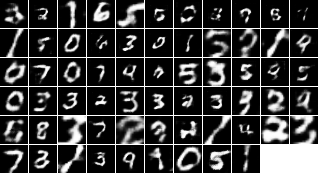

Target mask:


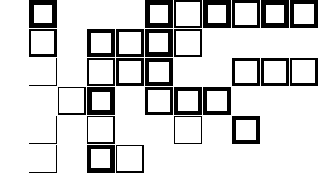

[     425 Epoch:[ 0/25] [  25/1093] time: 16.8385, d_loss: 1.52855134, g_loss: 2.23795915, walk_loss: 2.23795915
Target image:


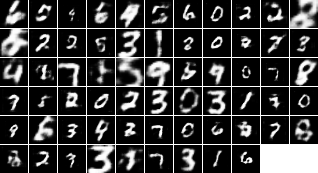

Target mask:


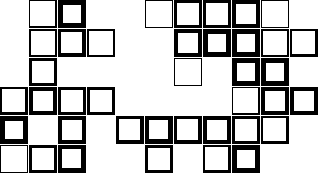

[     426 Epoch:[ 0/25] [  26/1093] time: 17.0952, d_loss: 1.49898636, g_loss: 2.19233847, walk_loss: 2.19233847
Target image:


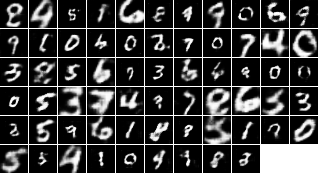

Target mask:


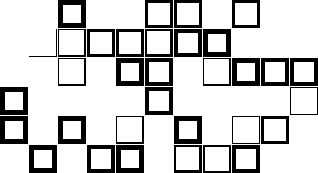

[     427 Epoch:[ 0/25] [  27/1093] time: 17.3628, d_loss: 1.50622892, g_loss: 2.21742773, walk_loss: 2.21742773
Target image:


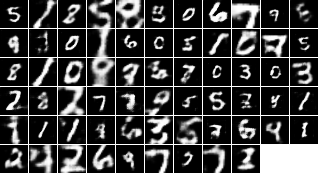

Target mask:


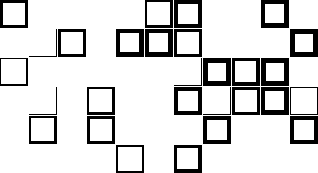

[     428 Epoch:[ 0/25] [  28/1093] time: 17.6089, d_loss: 1.50368094, g_loss: 2.21466327, walk_loss: 2.21466327
Target image:


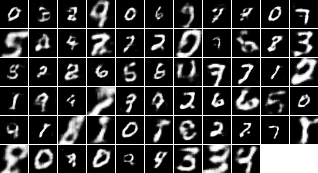

Target mask:


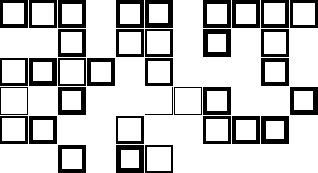

[     429 Epoch:[ 0/25] [  29/1093] time: 17.9039, d_loss: 1.49142623, g_loss: 2.20016479, walk_loss: 2.20016479
Target image:


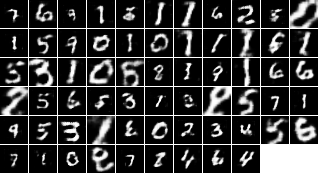

Target mask:


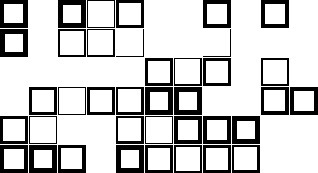

[     430 Epoch:[ 0/25] [  30/1093] time: 18.1776, d_loss: 1.49548459, g_loss: 2.17469049, walk_loss: 2.17469049
Target image:


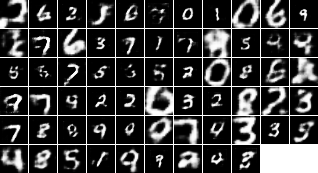

Target mask:


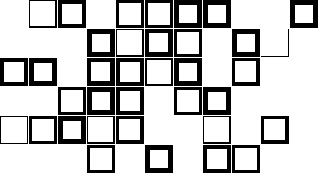

[     431 Epoch:[ 0/25] [  31/1093] time: 18.4533, d_loss: 1.48830247, g_loss: 2.24346113, walk_loss: 2.24346137
Target image:


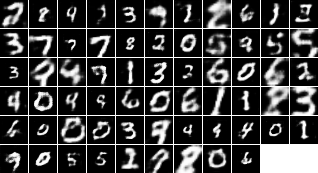

Target mask:


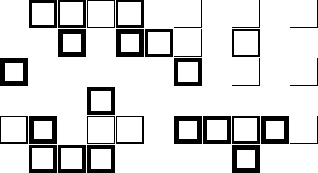

[     432 Epoch:[ 0/25] [  32/1093] time: 18.7451, d_loss: 1.50426531, g_loss: 2.21672225, walk_loss: 2.21672225
Target image:


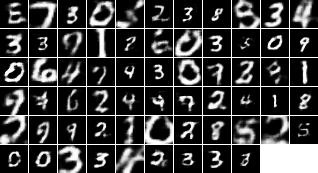

Target mask:


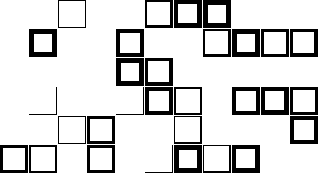

[     433 Epoch:[ 0/25] [  33/1093] time: 19.0430, d_loss: 1.51416790, g_loss: 2.25269032, walk_loss: 2.25269008
Target image:


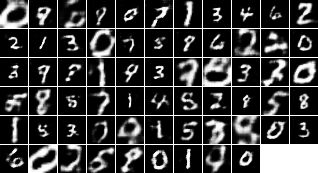

Target mask:


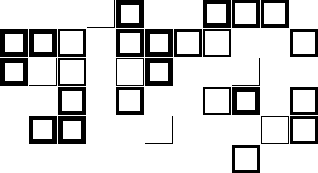

[     434 Epoch:[ 0/25] [  34/1093] time: 19.3203, d_loss: 1.49098682, g_loss: 2.21968198, walk_loss: 2.21968174
Target image:


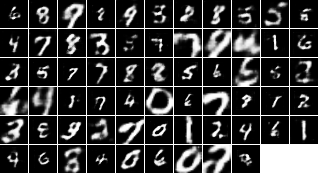

Target mask:


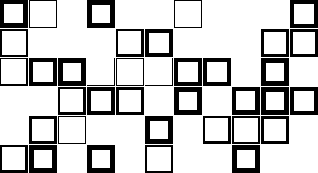

[     435 Epoch:[ 0/25] [  35/1093] time: 19.5920, d_loss: 1.49564493, g_loss: 2.21121144, walk_loss: 2.21121144
Target image:


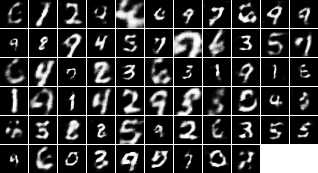

Target mask:


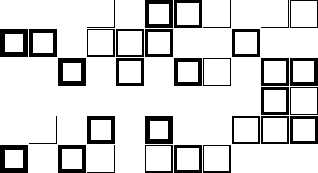

[     436 Epoch:[ 0/25] [  36/1093] time: 19.8438, d_loss: 1.48302317, g_loss: 2.19772601, walk_loss: 2.19772601
Target image:


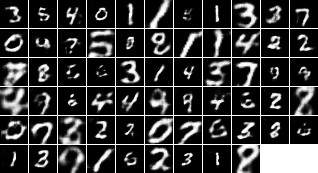

Target mask:


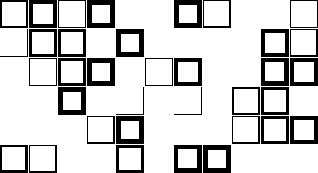

[     437 Epoch:[ 0/25] [  37/1093] time: 20.1289, d_loss: 1.47801745, g_loss: 2.20841622, walk_loss: 2.20841622
Target image:


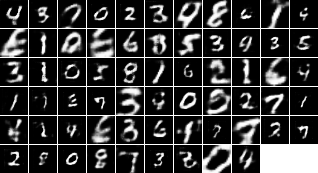

Target mask:


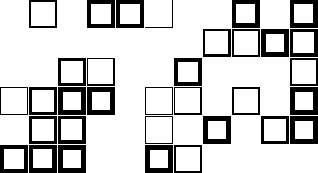

[     438 Epoch:[ 0/25] [  38/1093] time: 20.3821, d_loss: 1.48337054, g_loss: 2.21645641, walk_loss: 2.21645641
Target image:


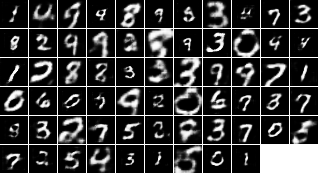

Target mask:


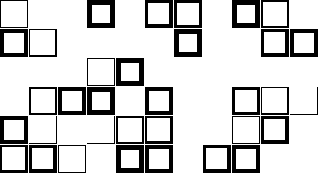

[     439 Epoch:[ 0/25] [  39/1093] time: 20.6683, d_loss: 1.48168540, g_loss: 2.19178677, walk_loss: 2.19178677
Target image:


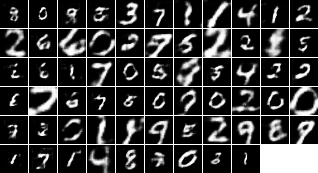

Target mask:


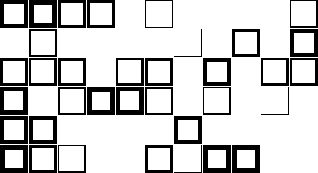

[     440 Epoch:[ 0/25] [  40/1093] time: 20.9496, d_loss: 1.50736022, g_loss: 2.20943809, walk_loss: 2.20943809
Target image:


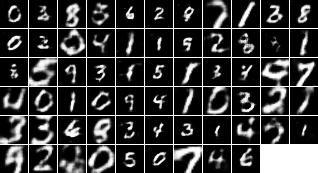

Target mask:


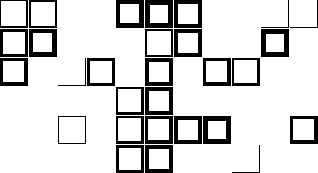

[     441 Epoch:[ 0/25] [  41/1093] time: 21.2461, d_loss: 1.51355362, g_loss: 2.22395802, walk_loss: 2.22395802
Target image:


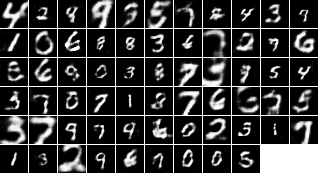

Target mask:


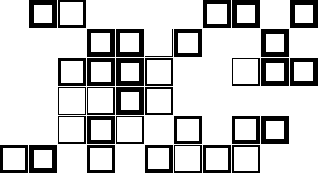

[     442 Epoch:[ 0/25] [  42/1093] time: 21.5248, d_loss: 1.52090669, g_loss: 2.20085359, walk_loss: 2.20085359
Target image:


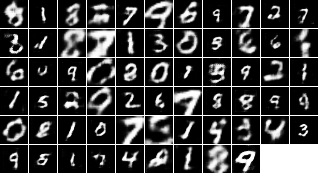

Target mask:


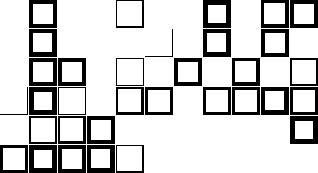

[     443 Epoch:[ 0/25] [  43/1093] time: 21.8245, d_loss: 1.50160122, g_loss: 2.21551323, walk_loss: 2.21551323
Target image:


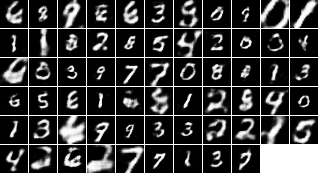

Target mask:


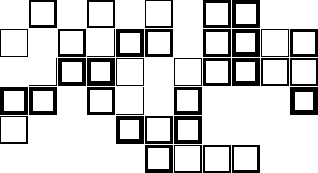

[     444 Epoch:[ 0/25] [  44/1093] time: 22.1059, d_loss: 1.49772251, g_loss: 2.21090221, walk_loss: 2.21090245
Target image:


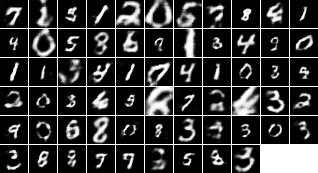

Target mask:


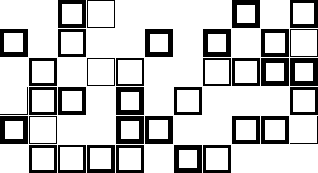

[     445 Epoch:[ 0/25] [  45/1093] time: 22.3950, d_loss: 1.50153983, g_loss: 2.20913005, walk_loss: 2.20913005
Target image:


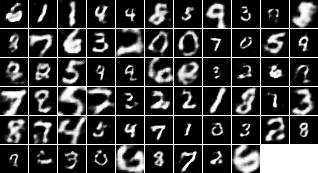

Target mask:


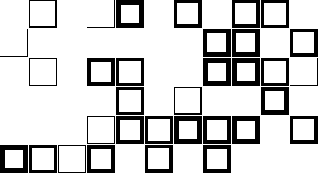

[     446 Epoch:[ 0/25] [  46/1093] time: 22.6606, d_loss: 1.49651217, g_loss: 2.23005891, walk_loss: 2.23005891
Target image:


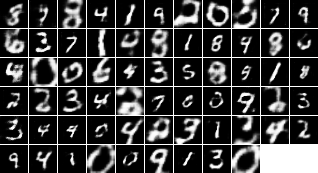

Target mask:


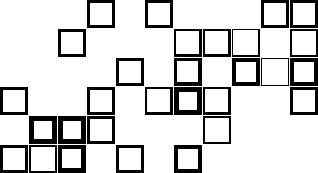

[     447 Epoch:[ 0/25] [  47/1093] time: 22.9257, d_loss: 1.49824429, g_loss: 2.23066711, walk_loss: 2.23066688
Target image:


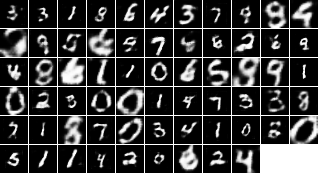

Target mask:


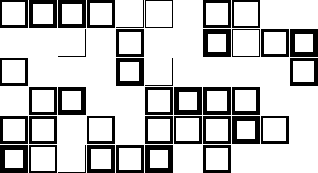

[     448 Epoch:[ 0/25] [  48/1093] time: 23.1709, d_loss: 1.48760343, g_loss: 2.21834993, walk_loss: 2.21835017
Target image:


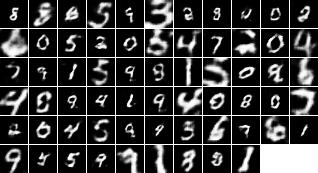

Target mask:


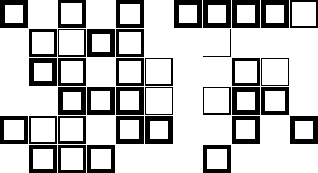

[     449 Epoch:[ 0/25] [  49/1093] time: 23.4470, d_loss: 1.49042881, g_loss: 2.21097159, walk_loss: 2.21097136
Target image:


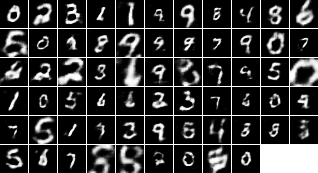

Target mask:


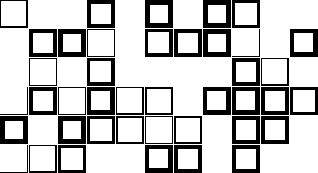

[     450 Epoch:[ 0/25] [  50/1093] time: 23.7243, d_loss: 1.49217343, g_loss: 2.21128011, walk_loss: 2.21127987
Target image:


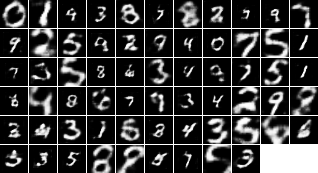

Target mask:


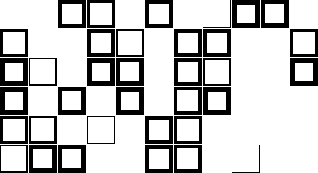

[     451 Epoch:[ 0/25] [  51/1093] time: 24.0099, d_loss: 1.49958801, g_loss: 2.24450421, walk_loss: 2.24450421
Target image:


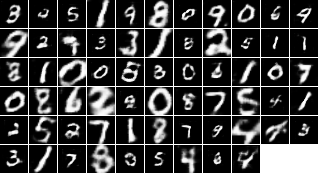

Target mask:


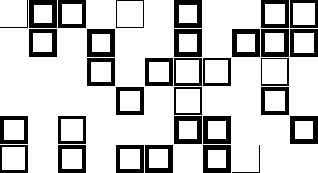

[     452 Epoch:[ 0/25] [  52/1093] time: 24.3050, d_loss: 1.49904037, g_loss: 2.24318790, walk_loss: 2.24318790
Target image:


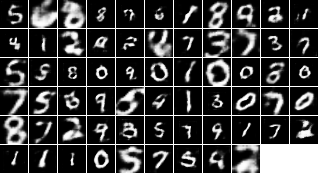

Target mask:


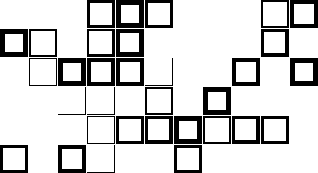

[     453 Epoch:[ 0/25] [  53/1093] time: 24.5885, d_loss: 1.50793827, g_loss: 2.21752143, walk_loss: 2.21752119
Target image:


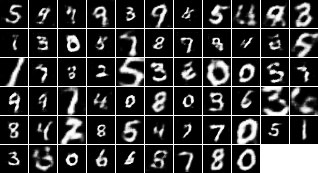

Target mask:


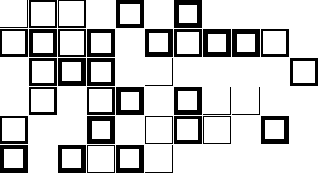

[     454 Epoch:[ 0/25] [  54/1093] time: 24.8649, d_loss: 1.50709152, g_loss: 2.20390868, walk_loss: 2.20390868
Target image:


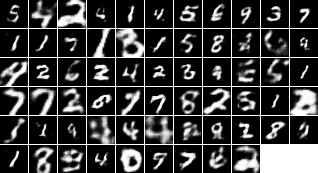

Target mask:


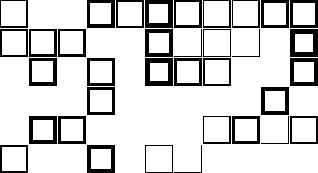

[     455 Epoch:[ 0/25] [  55/1093] time: 25.1153, d_loss: 1.50491738, g_loss: 2.20274591, walk_loss: 2.20274568
Target image:


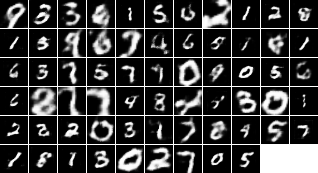

Target mask:


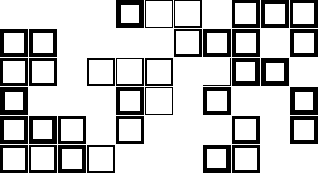

[     456 Epoch:[ 0/25] [  56/1093] time: 25.4077, d_loss: 1.50203371, g_loss: 2.21019959, walk_loss: 2.21019959
Target image:


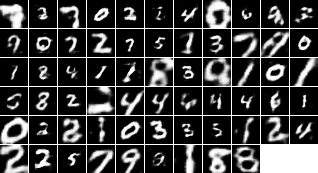

Target mask:


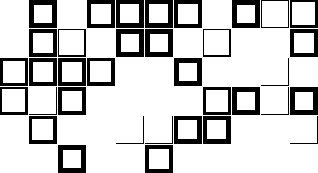

[     457 Epoch:[ 0/25] [  57/1093] time: 25.6687, d_loss: 1.50100470, g_loss: 2.22367477, walk_loss: 2.22367477
Target image:


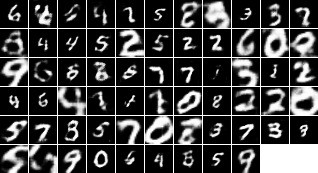

Target mask:


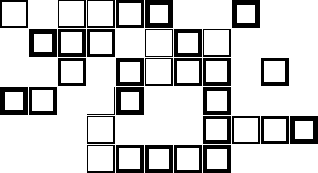

[     458 Epoch:[ 0/25] [  58/1093] time: 25.9284, d_loss: 1.50014853, g_loss: 2.20877814, walk_loss: 2.20877814
Target image:


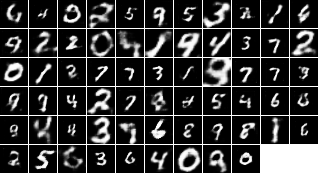

Target mask:


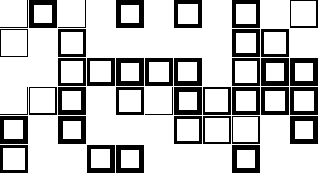

[     459 Epoch:[ 0/25] [  59/1093] time: 26.1755, d_loss: 1.49844337, g_loss: 2.19928837, walk_loss: 2.19928837
Target image:


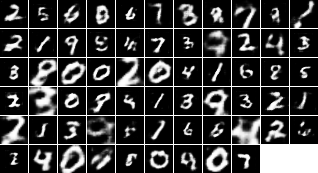

Target mask:


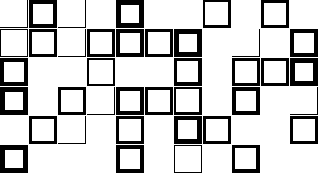

[     460 Epoch:[ 0/25] [  60/1093] time: 26.4182, d_loss: 1.49798656, g_loss: 2.22221994, walk_loss: 2.22221994
Target image:


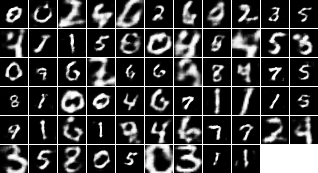

Target mask:


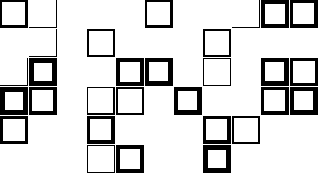

[     461 Epoch:[ 0/25] [  61/1093] time: 26.6829, d_loss: 1.49958992, g_loss: 2.19249010, walk_loss: 2.19248986
Target image:


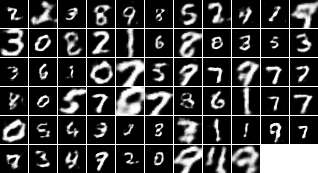

Target mask:


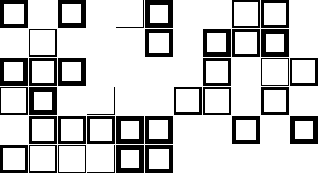

[     462 Epoch:[ 0/25] [  62/1093] time: 26.9276, d_loss: 1.49605465, g_loss: 2.21923780, walk_loss: 2.21923780
Target image:


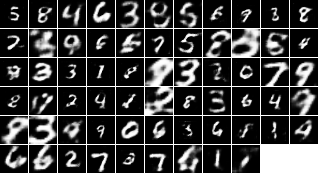

Target mask:


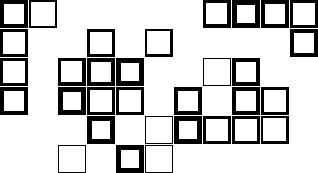

[     463 Epoch:[ 0/25] [  63/1093] time: 27.2146, d_loss: 1.51559091, g_loss: 2.22116256, walk_loss: 2.22116303
Target image:


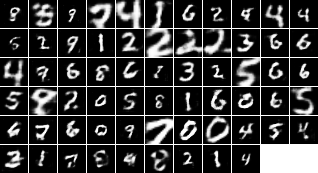

Target mask:


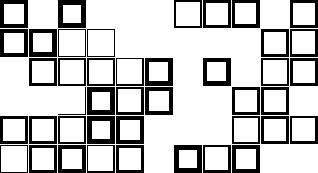

[     464 Epoch:[ 0/25] [  64/1093] time: 27.5140, d_loss: 1.50641012, g_loss: 2.24258780, walk_loss: 2.24258780
Target image:


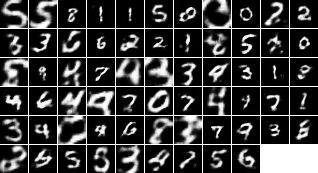

Target mask:


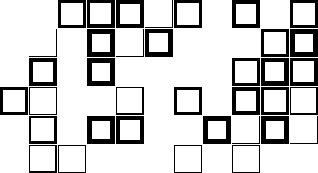

[     465 Epoch:[ 0/25] [  65/1093] time: 27.8001, d_loss: 1.49712420, g_loss: 2.24293494, walk_loss: 2.24293470
Target image:


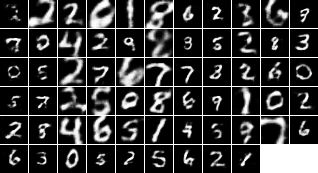

Target mask:


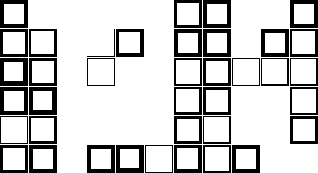

[     466 Epoch:[ 0/25] [  66/1093] time: 28.0478, d_loss: 1.49774885, g_loss: 2.23270631, walk_loss: 2.23270631
Target image:


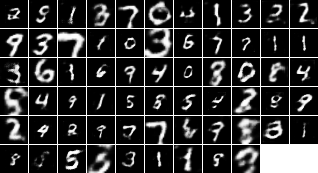

Target mask:


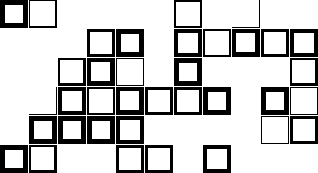

[     467 Epoch:[ 0/25] [  67/1093] time: 28.3495, d_loss: 1.50100183, g_loss: 2.20679092, walk_loss: 2.20679116
Target image:


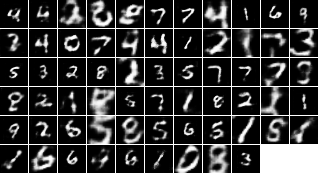

Target mask:


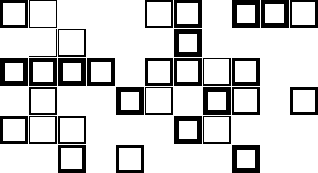

[     468 Epoch:[ 0/25] [  68/1093] time: 28.6144, d_loss: 1.51506662, g_loss: 2.19211030, walk_loss: 2.19211030
Target image:


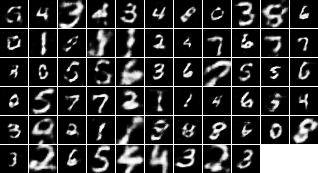

Target mask:


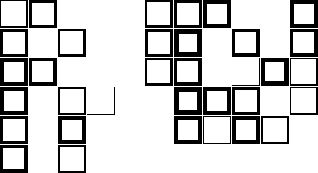

[     469 Epoch:[ 0/25] [  69/1093] time: 28.8964, d_loss: 1.48709595, g_loss: 2.20924449, walk_loss: 2.20924449
Target image:


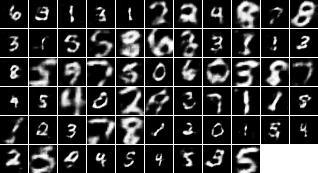

Target mask:


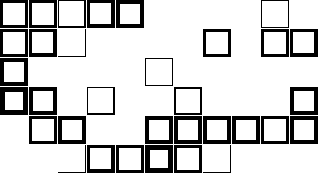

[     470 Epoch:[ 0/25] [  70/1093] time: 29.1728, d_loss: 1.49212193, g_loss: 2.21168065, walk_loss: 2.21168065
Target image:


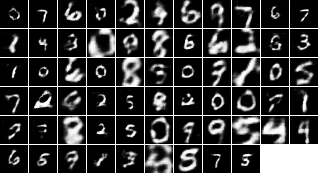

Target mask:


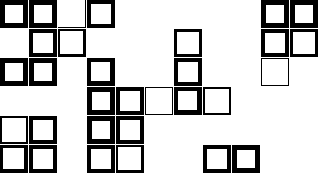

[     471 Epoch:[ 0/25] [  71/1093] time: 29.4650, d_loss: 1.51085854, g_loss: 2.22256994, walk_loss: 2.22256970
Target image:


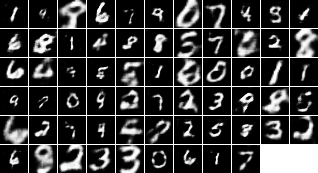

Target mask:


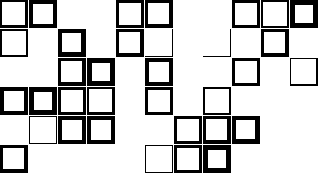

[     472 Epoch:[ 0/25] [  72/1093] time: 29.7498, d_loss: 1.49917710, g_loss: 2.21456170, walk_loss: 2.21456146
Target image:


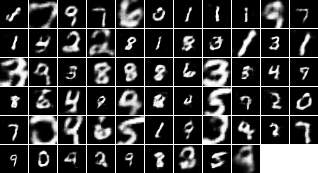

Target mask:


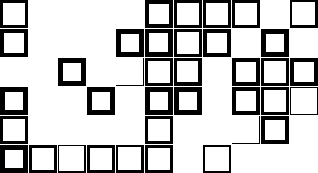

[     473 Epoch:[ 0/25] [  73/1093] time: 30.0512, d_loss: 1.49155366, g_loss: 2.20125270, walk_loss: 2.20125270
Target image:


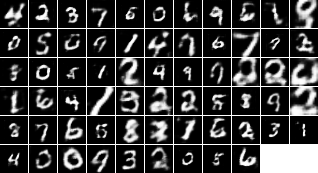

Target mask:


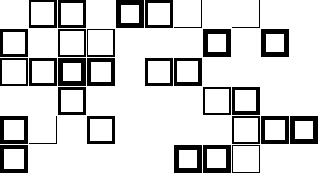

[     474 Epoch:[ 0/25] [  74/1093] time: 30.3186, d_loss: 1.51524460, g_loss: 2.18018532, walk_loss: 2.18018532
Target image:


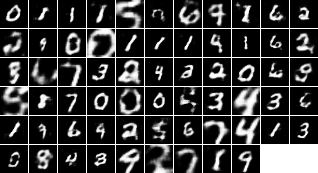

Target mask:


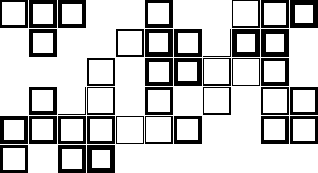

[     475 Epoch:[ 0/25] [  75/1093] time: 30.5936, d_loss: 1.49557066, g_loss: 2.23045421, walk_loss: 2.23045421
Target image:


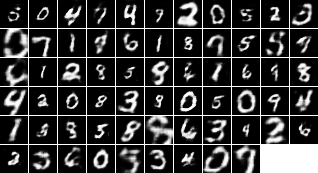

Target mask:


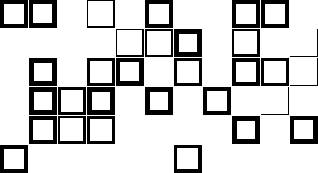

[     476 Epoch:[ 0/25] [  76/1093] time: 30.8532, d_loss: 1.50985217, g_loss: 2.17201710, walk_loss: 2.17201734
Target image:


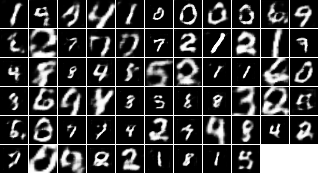

Target mask:


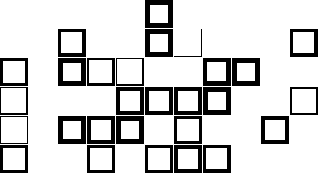

[     477 Epoch:[ 0/25] [  77/1093] time: 31.1213, d_loss: 1.49952269, g_loss: 2.19417000, walk_loss: 2.19417000
Target image:


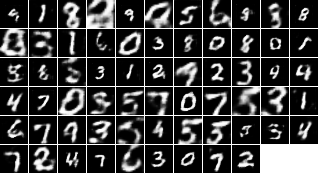

Target mask:


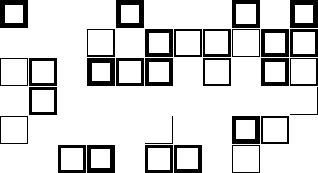

[     478 Epoch:[ 0/25] [  78/1093] time: 31.3895, d_loss: 1.50703144, g_loss: 2.18994379, walk_loss: 2.18994379
Target image:


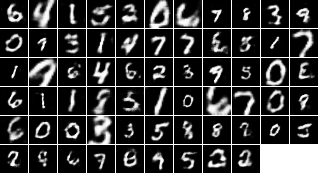

Target mask:


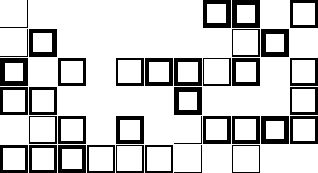

[     479 Epoch:[ 0/25] [  79/1093] time: 31.6805, d_loss: 1.49380255, g_loss: 2.20610595, walk_loss: 2.20610595
Target image:


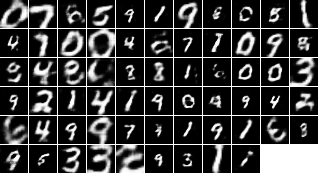

Target mask:


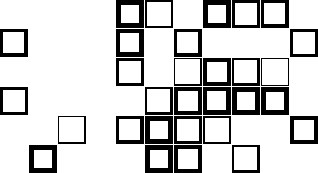

[     480 Epoch:[ 0/25] [  80/1093] time: 31.9445, d_loss: 1.49696374, g_loss: 2.21289229, walk_loss: 2.21289229
Target image:


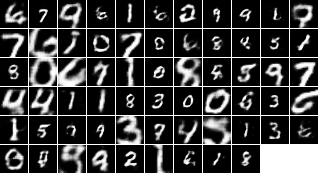

Target mask:


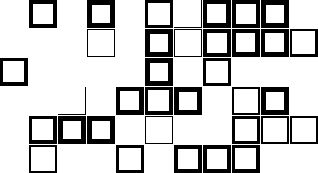

[     481 Epoch:[ 0/25] [  81/1093] time: 32.2408, d_loss: 1.51847982, g_loss: 2.20503092, walk_loss: 2.20503092
Target image:


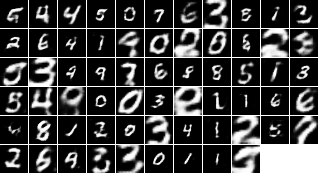

Target mask:


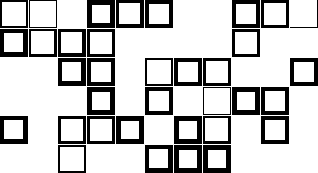

[     482 Epoch:[ 0/25] [  82/1093] time: 32.5163, d_loss: 1.50533092, g_loss: 2.24744868, walk_loss: 2.24744868
Target image:


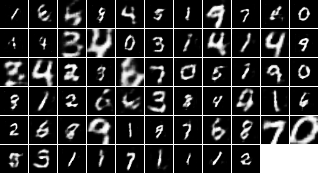

Target mask:


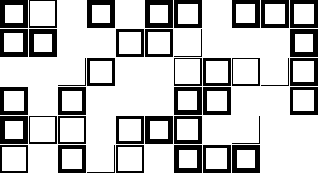

[     483 Epoch:[ 0/25] [  83/1093] time: 32.8009, d_loss: 1.50214934, g_loss: 2.22999549, walk_loss: 2.22999573
Target image:


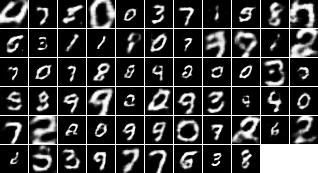

Target mask:


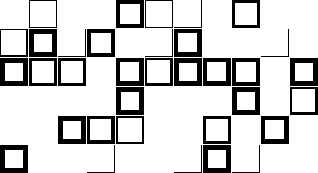

[     484 Epoch:[ 0/25] [  84/1093] time: 33.0677, d_loss: 1.50043964, g_loss: 2.20442963, walk_loss: 2.20442963
Target image:


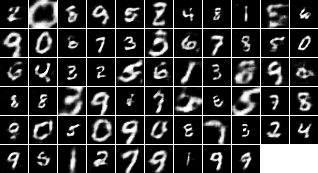

Target mask:


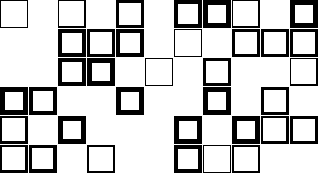

[     485 Epoch:[ 0/25] [  85/1093] time: 33.3421, d_loss: 1.49330497, g_loss: 2.20841026, walk_loss: 2.20841026
Target image:


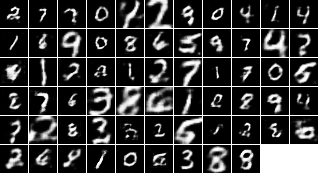

Target mask:


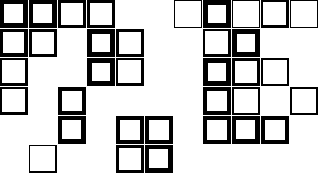

[     486 Epoch:[ 0/25] [  86/1093] time: 33.6256, d_loss: 1.49931872, g_loss: 2.21416545, walk_loss: 2.21416545
Target image:


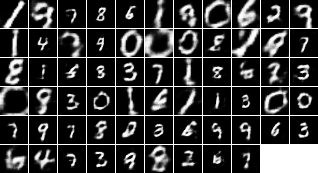

Target mask:


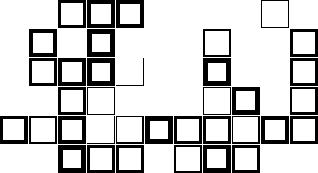

[     487 Epoch:[ 0/25] [  87/1093] time: 33.8901, d_loss: 1.50186908, g_loss: 2.19478846, walk_loss: 2.19478846
Target image:


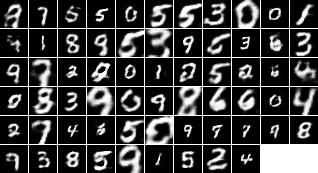

Target mask:


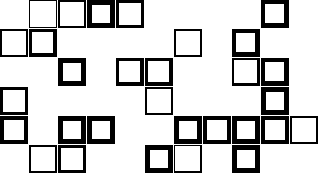

[     488 Epoch:[ 0/25] [  88/1093] time: 34.1841, d_loss: 1.50666928, g_loss: 2.20038939, walk_loss: 2.20038939
Target image:


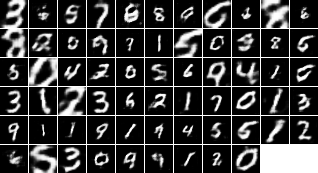

Target mask:


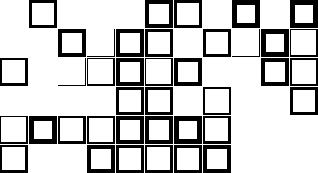

[     489 Epoch:[ 0/25] [  89/1093] time: 34.4616, d_loss: 1.49138188, g_loss: 2.21730685, walk_loss: 2.21730685
Target image:


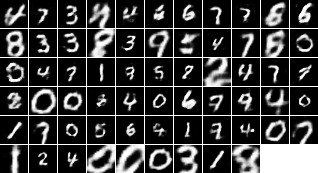

Target mask:


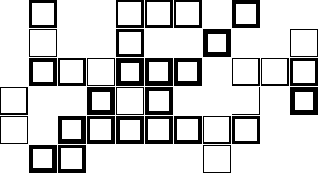

[     490 Epoch:[ 0/25] [  90/1093] time: 34.7586, d_loss: 1.50342858, g_loss: 2.19658065, walk_loss: 2.19658065
Target image:


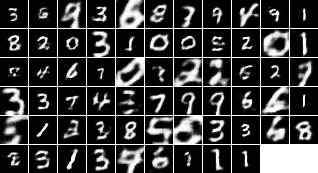

Target mask:


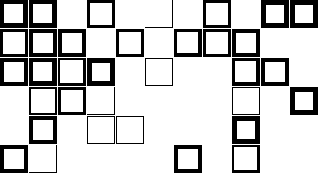

[     491 Epoch:[ 0/25] [  91/1093] time: 35.0274, d_loss: 1.49563050, g_loss: 2.22665262, walk_loss: 2.22665262
Target image:


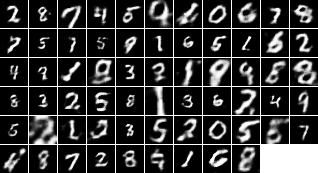

Target mask:


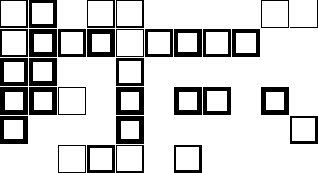

[     492 Epoch:[ 0/25] [  92/1093] time: 35.3080, d_loss: 1.50200248, g_loss: 2.19495296, walk_loss: 2.19495296
Target image:


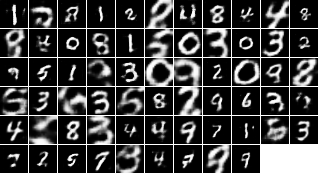

Target mask:


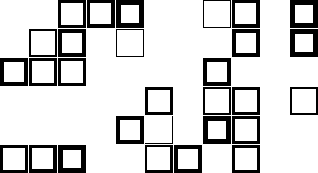

[     493 Epoch:[ 0/25] [  93/1093] time: 35.6126, d_loss: 1.51216567, g_loss: 2.24545240, walk_loss: 2.24545240
Target image:


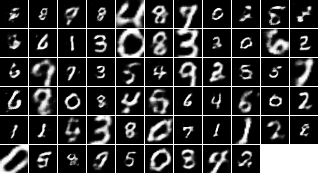

Target mask:


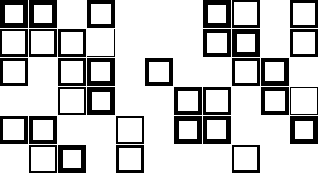

[     494 Epoch:[ 0/25] [  94/1093] time: 35.8521, d_loss: 1.49189973, g_loss: 2.21348786, walk_loss: 2.21348786
Target image:


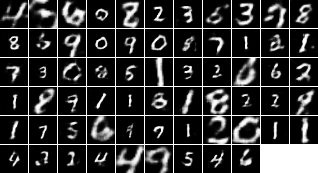

Target mask:


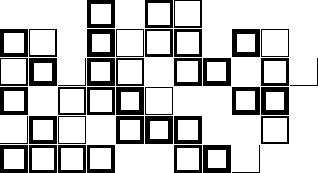

[     495 Epoch:[ 0/25] [  95/1093] time: 36.1364, d_loss: 1.49110293, g_loss: 2.21394157, walk_loss: 2.21394134
Target image:


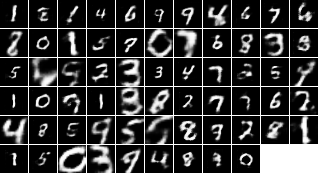

Target mask:


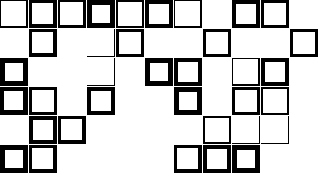

[     496 Epoch:[ 0/25] [  96/1093] time: 36.4327, d_loss: 1.49630928, g_loss: 2.22438192, walk_loss: 2.22438192
Target image:


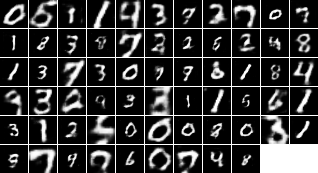

Target mask:


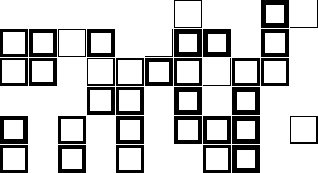

[     497 Epoch:[ 0/25] [  97/1093] time: 36.7234, d_loss: 1.48271322, g_loss: 2.19005227, walk_loss: 2.19005227
Target image:


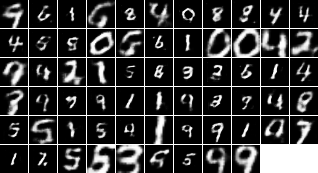

Target mask:


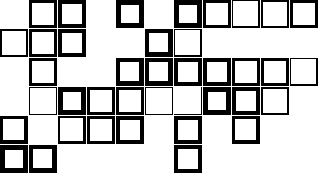

[     498 Epoch:[ 0/25] [  98/1093] time: 37.0268, d_loss: 1.51514816, g_loss: 2.21865392, walk_loss: 2.21865392
Target image:


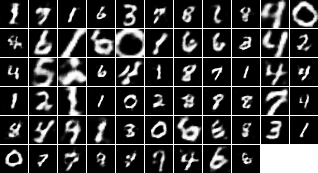

Target mask:


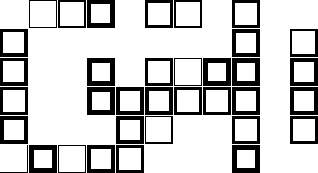

[     499 Epoch:[ 0/25] [  99/1093] time: 37.3267, d_loss: 1.50298762, g_loss: 2.18465114, walk_loss: 2.18465114
Target image:


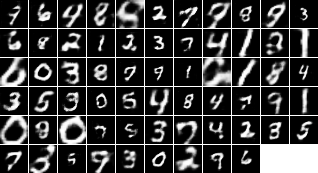

Target mask:


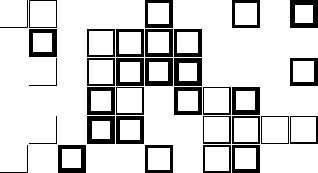

[     500 Epoch:[ 0/25] [ 100/1093] time: 37.6343, d_loss: 1.50948954, g_loss: 2.19474864, walk_loss: 2.19474864
Target image:


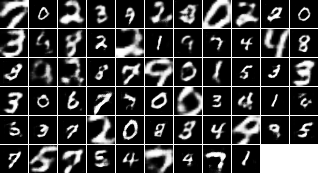

Target mask:


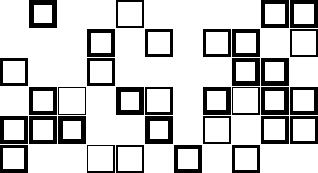

[     501 Epoch:[ 0/25] [ 101/1093] time: 37.9363, d_loss: 1.49449480, g_loss: 2.22490740, walk_loss: 2.22490740
Target image:


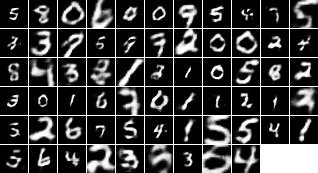

Target mask:


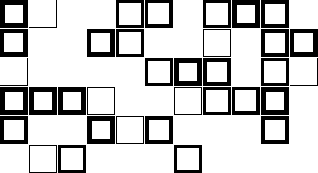

[     502 Epoch:[ 0/25] [ 102/1093] time: 38.2030, d_loss: 1.51558948, g_loss: 2.20520329, walk_loss: 2.20520329
Target image:


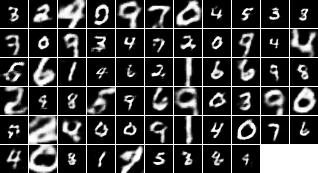

Target mask:


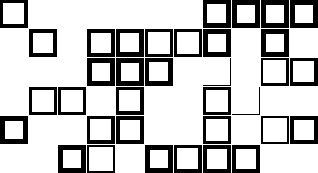

[     503 Epoch:[ 0/25] [ 103/1093] time: 38.4701, d_loss: 1.50594759, g_loss: 2.20395041, walk_loss: 2.20395041
Target image:


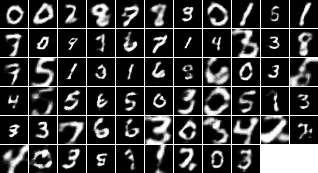

Target mask:


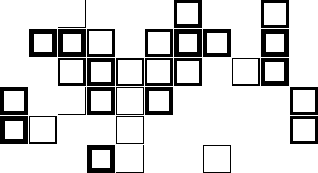

[     504 Epoch:[ 0/25] [ 104/1093] time: 38.7361, d_loss: 1.50014830, g_loss: 2.21635509, walk_loss: 2.21635509
Target image:


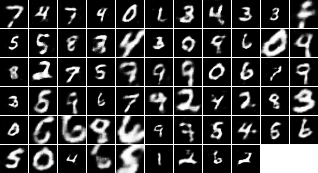

Target mask:


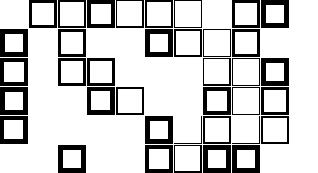

[     505 Epoch:[ 0/25] [ 105/1093] time: 39.0197, d_loss: 1.49726677, g_loss: 2.21604371, walk_loss: 2.21604371
Target image:


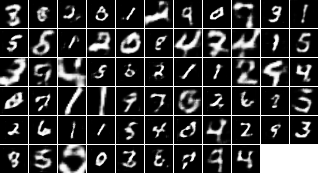

Target mask:


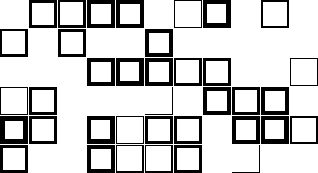

[     506 Epoch:[ 0/25] [ 106/1093] time: 39.2896, d_loss: 1.49326682, g_loss: 2.20583940, walk_loss: 2.20583963
Target image:


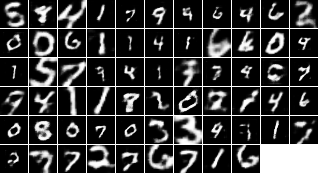

Target mask:


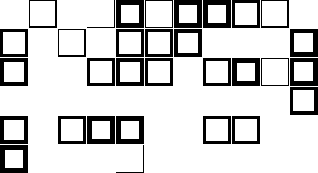

[     507 Epoch:[ 0/25] [ 107/1093] time: 39.5858, d_loss: 1.49131703, g_loss: 2.21201706, walk_loss: 2.21201706
Target image:


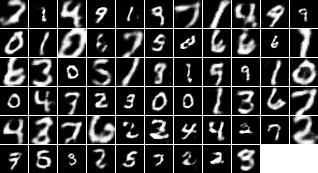

Target mask:


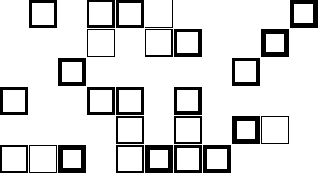

[     508 Epoch:[ 0/25] [ 108/1093] time: 39.8346, d_loss: 1.49772930, g_loss: 2.22944832, walk_loss: 2.22944832
Target image:


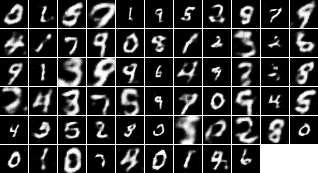

Target mask:


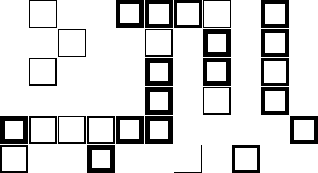

[     509 Epoch:[ 0/25] [ 109/1093] time: 40.0844, d_loss: 1.49867499, g_loss: 2.21425343, walk_loss: 2.21425343
Target image:


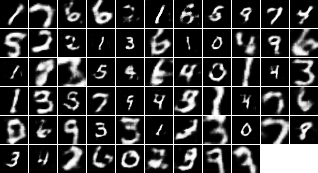

Target mask:


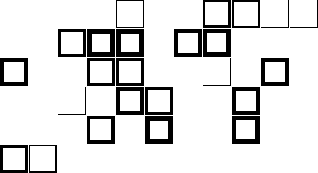

[     510 Epoch:[ 0/25] [ 110/1093] time: 40.3701, d_loss: 1.48172617, g_loss: 2.22672844, walk_loss: 2.22672844
Target image:


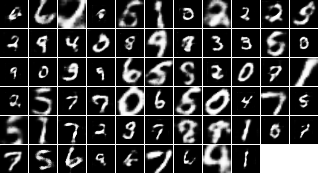

Target mask:


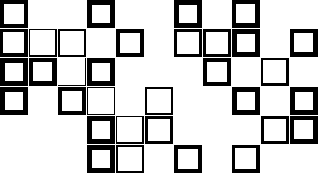

[     511 Epoch:[ 0/25] [ 111/1093] time: 40.6527, d_loss: 1.48687422, g_loss: 2.24710369, walk_loss: 2.24710369
Target image:


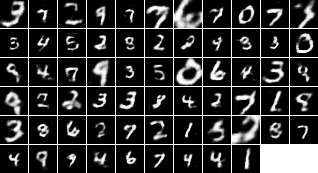

Target mask:


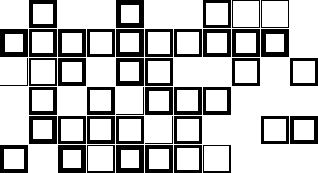

[     512 Epoch:[ 0/25] [ 112/1093] time: 40.9147, d_loss: 1.50078499, g_loss: 2.19430590, walk_loss: 2.19430566
Target image:


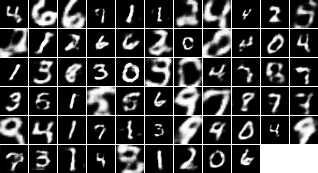

Target mask:


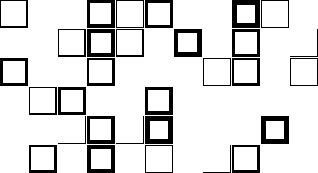

[     513 Epoch:[ 0/25] [ 113/1093] time: 41.2018, d_loss: 1.51428580, g_loss: 2.20092893, walk_loss: 2.20092916
Target image:


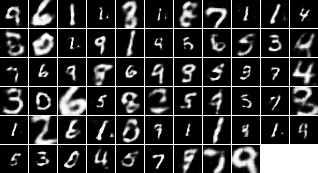

Target mask:


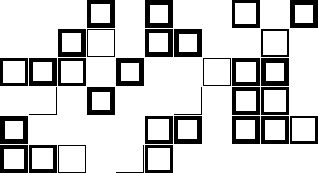

[     514 Epoch:[ 0/25] [ 114/1093] time: 41.4426, d_loss: 1.49947309, g_loss: 2.20877361, walk_loss: 2.20877361
Target image:


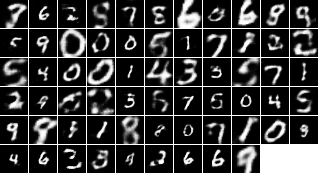

Target mask:


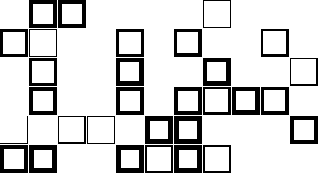

[     515 Epoch:[ 0/25] [ 115/1093] time: 41.6955, d_loss: 1.50483000, g_loss: 2.22947478, walk_loss: 2.22947478
Target image:


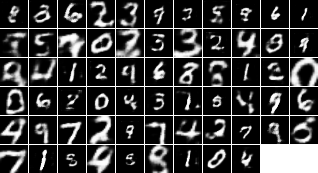

Target mask:


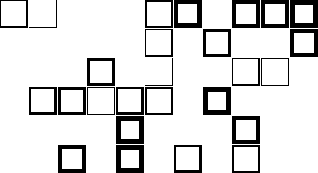

[     516 Epoch:[ 0/25] [ 116/1093] time: 41.9651, d_loss: 1.47820520, g_loss: 2.22766662, walk_loss: 2.22766662
Target image:


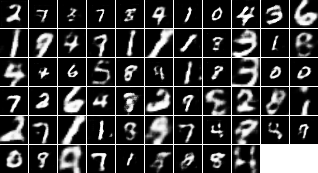

Target mask:


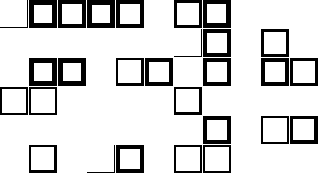

[     517 Epoch:[ 0/25] [ 117/1093] time: 42.2538, d_loss: 1.49913108, g_loss: 2.20068026, walk_loss: 2.20068026
Target image:


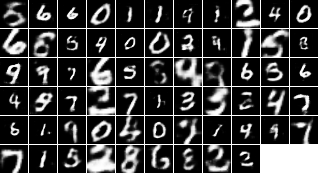

Target mask:


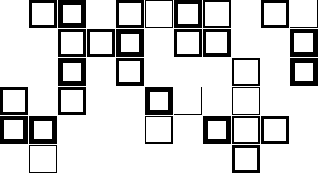

[     518 Epoch:[ 0/25] [ 118/1093] time: 42.5202, d_loss: 1.49548614, g_loss: 2.22270298, walk_loss: 2.22270322
Target image:


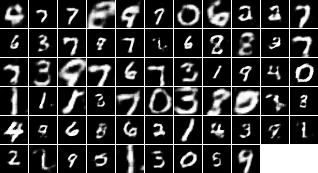

Target mask:


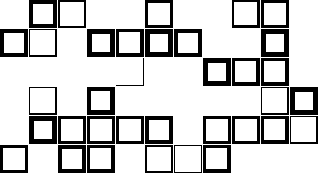

[     519 Epoch:[ 0/25] [ 119/1093] time: 42.8089, d_loss: 1.50310373, g_loss: 2.18093634, walk_loss: 2.18093634
Target image:


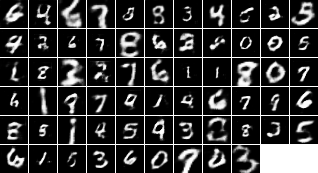

Target mask:


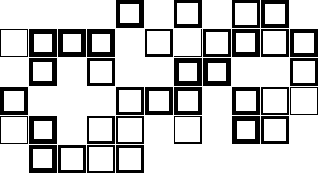

[     520 Epoch:[ 0/25] [ 120/1093] time: 43.0924, d_loss: 1.50833464, g_loss: 2.18585753, walk_loss: 2.18585730
Target image:


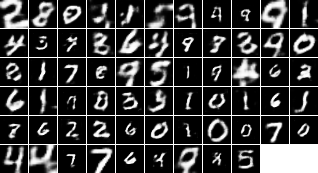

Target mask:


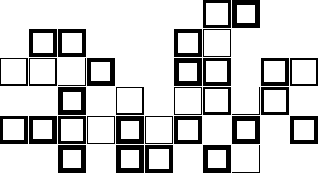

[     521 Epoch:[ 0/25] [ 121/1093] time: 43.3650, d_loss: 1.50920868, g_loss: 2.18801022, walk_loss: 2.18801022
Target image:


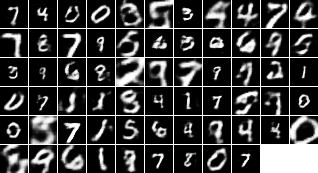

Target mask:


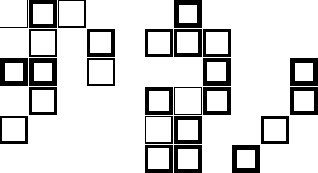

[     522 Epoch:[ 0/25] [ 122/1093] time: 43.6219, d_loss: 1.50102615, g_loss: 2.21286845, walk_loss: 2.21286845
Target image:


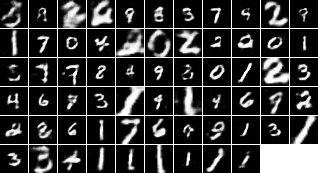

Target mask:


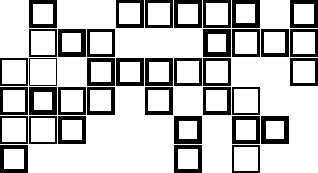

[     523 Epoch:[ 0/25] [ 123/1093] time: 43.8684, d_loss: 1.49505067, g_loss: 2.21531606, walk_loss: 2.21531606
Target image:


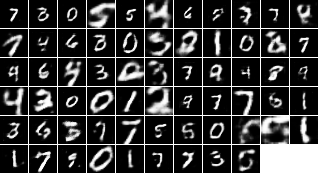

Target mask:


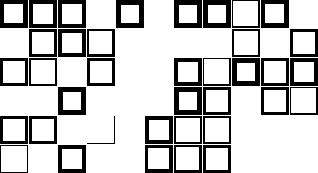

[     524 Epoch:[ 0/25] [ 124/1093] time: 44.1539, d_loss: 1.49584746, g_loss: 2.22677755, walk_loss: 2.22677755
Target image:


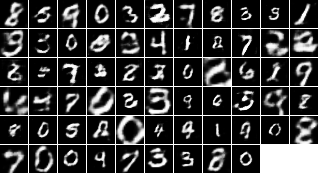

Target mask:


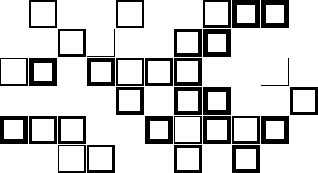

[     525 Epoch:[ 0/25] [ 125/1093] time: 44.4453, d_loss: 1.49134994, g_loss: 2.22268510, walk_loss: 2.22268510
Target image:


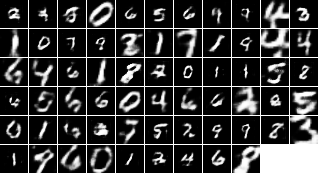

Target mask:


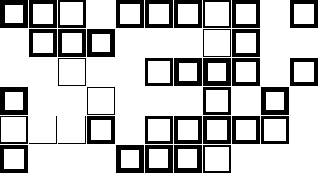

[     526 Epoch:[ 0/25] [ 126/1093] time: 44.7292, d_loss: 1.48688412, g_loss: 2.23756862, walk_loss: 2.23756862
Target image:


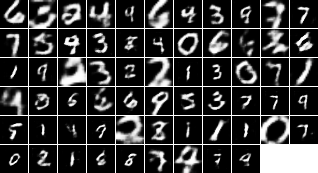

Target mask:


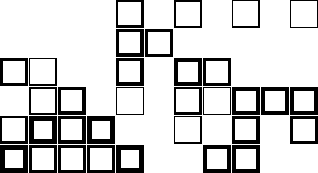

[     527 Epoch:[ 0/25] [ 127/1093] time: 45.0411, d_loss: 1.48935139, g_loss: 2.21022153, walk_loss: 2.21022153
Target image:


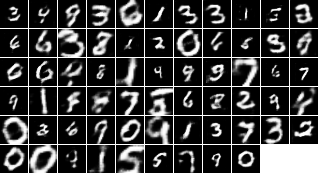

Target mask:


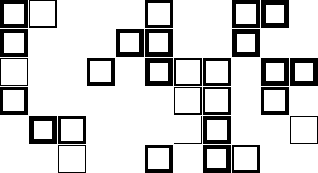

[     528 Epoch:[ 0/25] [ 128/1093] time: 45.3035, d_loss: 1.50782311, g_loss: 2.18724895, walk_loss: 2.18724895
Target image:


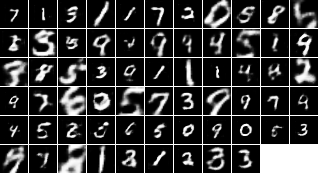

Target mask:


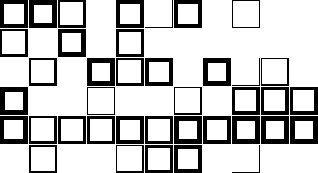

[     529 Epoch:[ 0/25] [ 129/1093] time: 45.5968, d_loss: 1.51249075, g_loss: 2.21865106, walk_loss: 2.21865106
Target image:


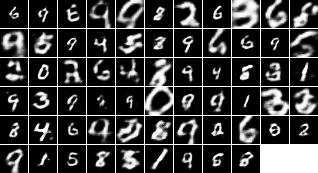

Target mask:


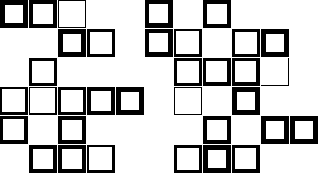

[     530 Epoch:[ 0/25] [ 130/1093] time: 45.8953, d_loss: 1.48988152, g_loss: 2.22912788, walk_loss: 2.22912788
Target image:


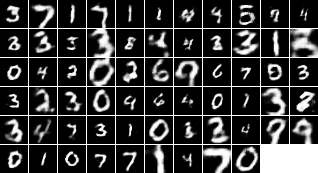

Target mask:


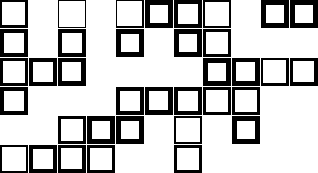

[     531 Epoch:[ 0/25] [ 131/1093] time: 46.1440, d_loss: 1.50403488, g_loss: 2.20529747, walk_loss: 2.20529747
Target image:


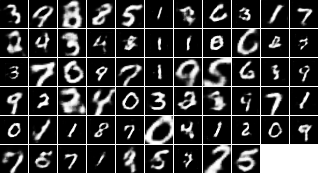

Target mask:


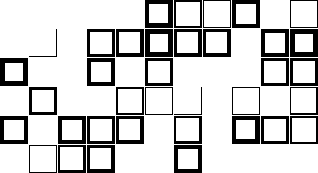

[     532 Epoch:[ 0/25] [ 132/1093] time: 46.4387, d_loss: 1.49449468, g_loss: 2.18464923, walk_loss: 2.18464923
Target image:


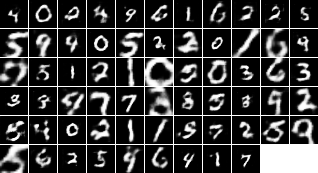

Target mask:


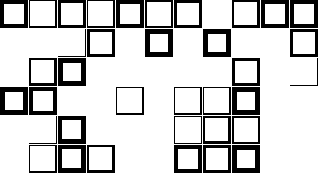

[     533 Epoch:[ 0/25] [ 133/1093] time: 46.7410, d_loss: 1.50387371, g_loss: 2.18351674, walk_loss: 2.18351674
Target image:


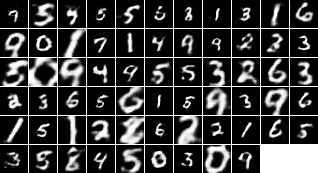

Target mask:


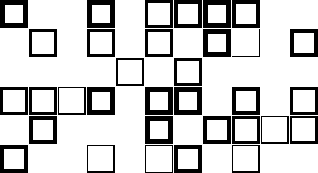

[     534 Epoch:[ 0/25] [ 134/1093] time: 47.0276, d_loss: 1.50433135, g_loss: 2.21190739, walk_loss: 2.21190739
Target image:


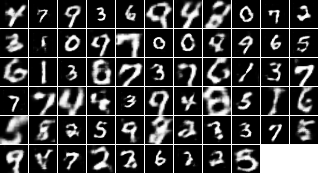

Target mask:


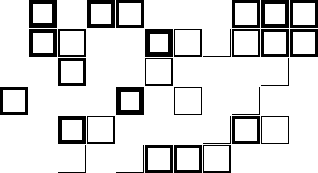

[     535 Epoch:[ 0/25] [ 135/1093] time: 47.3214, d_loss: 1.50033569, g_loss: 2.20955658, walk_loss: 2.20955658
Target image:


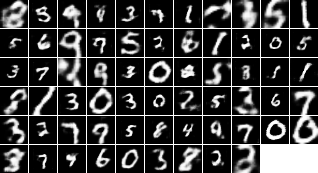

Target mask:


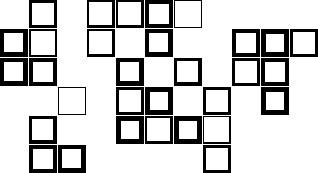

[     536 Epoch:[ 0/25] [ 136/1093] time: 47.6051, d_loss: 1.49334860, g_loss: 2.22763300, walk_loss: 2.22763300
Target image:


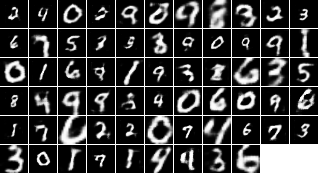

Target mask:


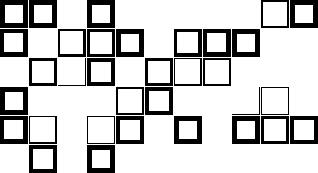

[     537 Epoch:[ 0/25] [ 137/1093] time: 47.8872, d_loss: 1.49976325, g_loss: 2.21351457, walk_loss: 2.21351457
Target image:


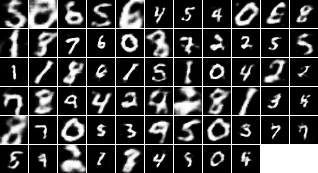

Target mask:


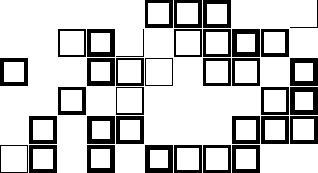

[     538 Epoch:[ 0/25] [ 138/1093] time: 48.1890, d_loss: 1.49155867, g_loss: 2.22874475, walk_loss: 2.22874475
Target image:


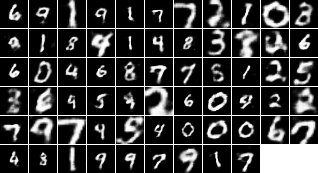

Target mask:


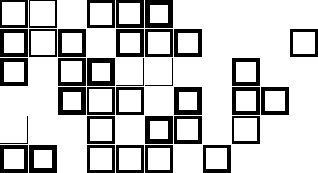

[     539 Epoch:[ 0/25] [ 139/1093] time: 48.4817, d_loss: 1.49591875, g_loss: 2.19198561, walk_loss: 2.19198585
Target image:


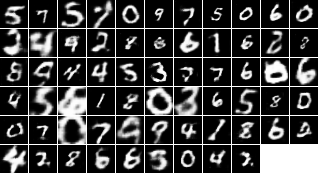

Target mask:


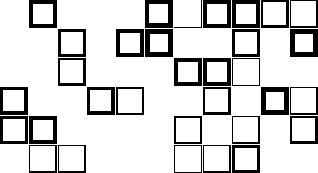

[     540 Epoch:[ 0/25] [ 140/1093] time: 48.7465, d_loss: 1.49977219, g_loss: 2.21637797, walk_loss: 2.21637797
Target image:


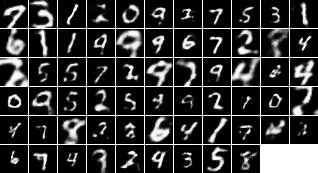

Target mask:


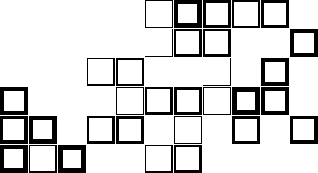

[     541 Epoch:[ 0/25] [ 141/1093] time: 49.0187, d_loss: 1.49334574, g_loss: 2.19284606, walk_loss: 2.19284606
Target image:


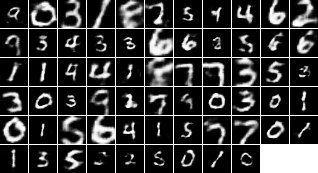

Target mask:


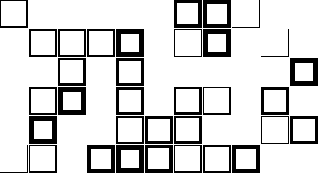

[     542 Epoch:[ 0/25] [ 142/1093] time: 49.2838, d_loss: 1.50035381, g_loss: 2.20606971, walk_loss: 2.20606971
Target image:


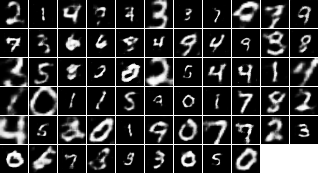

Target mask:


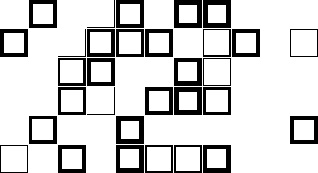

[     543 Epoch:[ 0/25] [ 143/1093] time: 49.5793, d_loss: 1.50421429, g_loss: 2.20225310, walk_loss: 2.20225310
Target image:


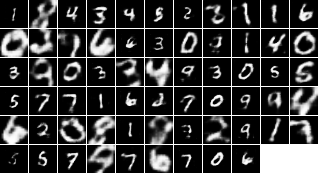

Target mask:


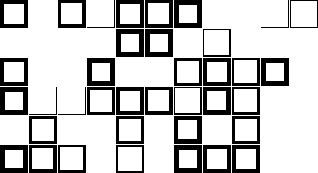

[     544 Epoch:[ 0/25] [ 144/1093] time: 49.8715, d_loss: 1.49496031, g_loss: 2.23498750, walk_loss: 2.23498750
Target image:


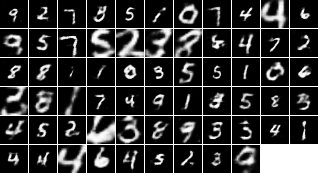

Target mask:


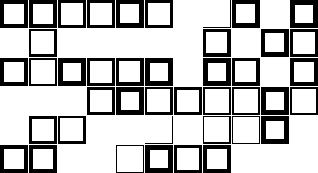

[     545 Epoch:[ 0/25] [ 145/1093] time: 50.1378, d_loss: 1.49845004, g_loss: 2.20163727, walk_loss: 2.20163727
Target image:


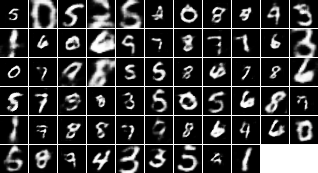

Target mask:


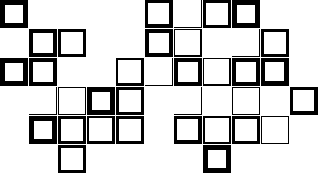

[     546 Epoch:[ 0/25] [ 146/1093] time: 50.4335, d_loss: 1.47948647, g_loss: 2.21991014, walk_loss: 2.21991014
Target image:


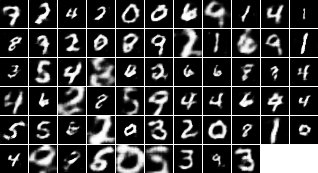

Target mask:


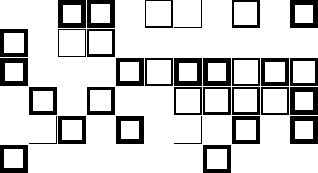

[     547 Epoch:[ 0/25] [ 147/1093] time: 50.7031, d_loss: 1.49714911, g_loss: 2.18983507, walk_loss: 2.18983507
Target image:


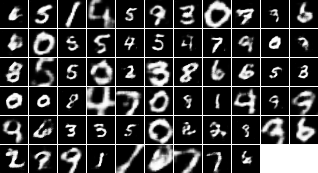

Target mask:


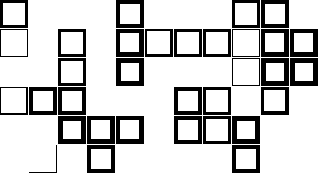

[     548 Epoch:[ 0/25] [ 148/1093] time: 50.9677, d_loss: 1.49893701, g_loss: 2.19342875, walk_loss: 2.19342852
Target image:


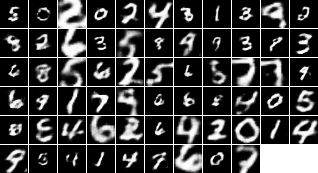

Target mask:


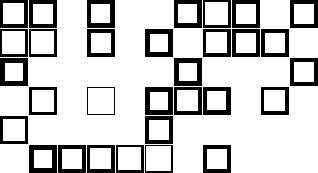

[     549 Epoch:[ 0/25] [ 149/1093] time: 51.2585, d_loss: 1.50460994, g_loss: 2.19203115, walk_loss: 2.19203115
Target image:


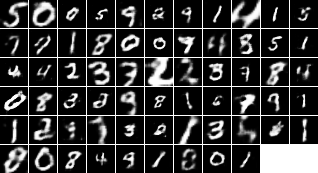

Target mask:


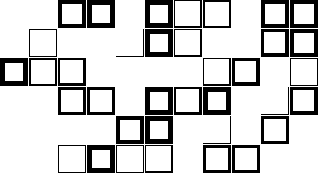

[     550 Epoch:[ 0/25] [ 150/1093] time: 51.5508, d_loss: 1.49775851, g_loss: 2.17540550, walk_loss: 2.17540550
Target image:


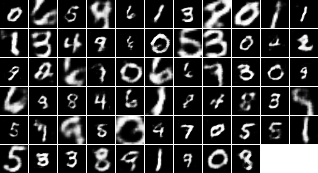

Target mask:


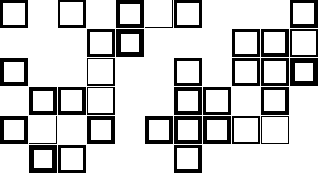

[     551 Epoch:[ 0/25] [ 151/1093] time: 51.8054, d_loss: 1.50244594, g_loss: 2.19187713, walk_loss: 2.19187713
Target image:


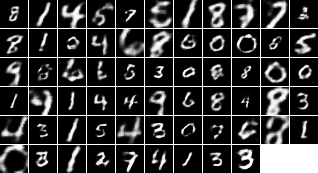

Target mask:


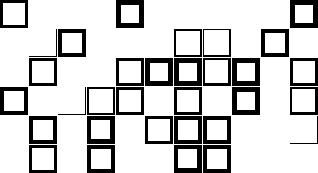

[     552 Epoch:[ 0/25] [ 152/1093] time: 52.0817, d_loss: 1.49302435, g_loss: 2.20608783, walk_loss: 2.20608783
Target image:


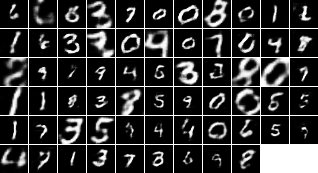

Target mask:


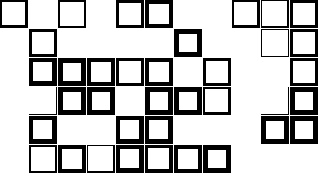

[     553 Epoch:[ 0/25] [ 153/1093] time: 52.3799, d_loss: 1.48560643, g_loss: 2.24613309, walk_loss: 2.24613309
Target image:


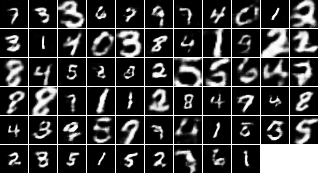

Target mask:


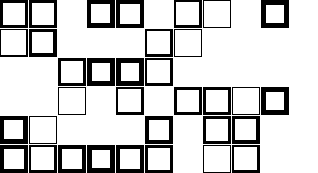

[     554 Epoch:[ 0/25] [ 154/1093] time: 52.6493, d_loss: 1.49197936, g_loss: 2.21451497, walk_loss: 2.21451497
Target image:


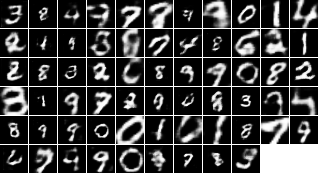

Target mask:


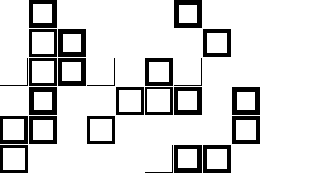

[     555 Epoch:[ 0/25] [ 155/1093] time: 52.9491, d_loss: 1.48954105, g_loss: 2.21161985, walk_loss: 2.21161985
Target image:


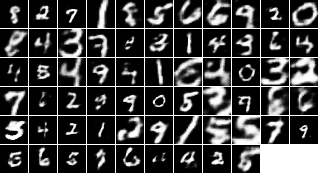

Target mask:


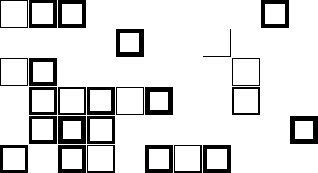

[     556 Epoch:[ 0/25] [ 156/1093] time: 53.2369, d_loss: 1.48994756, g_loss: 2.20934391, walk_loss: 2.20934391
Target image:


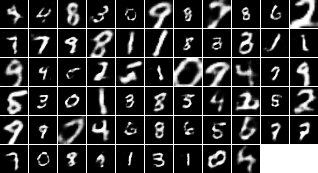

Target mask:


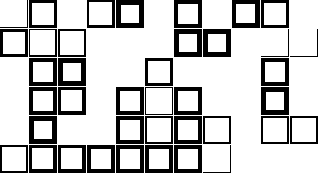

[     557 Epoch:[ 0/25] [ 157/1093] time: 53.5101, d_loss: 1.49650097, g_loss: 2.19807529, walk_loss: 2.19807577
Target image:


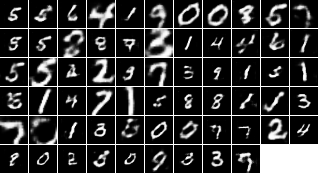

Target mask:


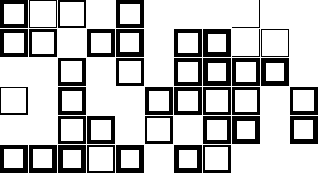

[     558 Epoch:[ 0/25] [ 158/1093] time: 53.8000, d_loss: 1.49290037, g_loss: 2.18127322, walk_loss: 2.18127322
Target image:


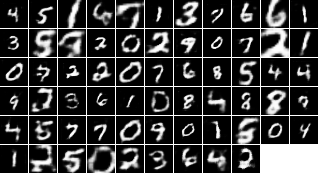

Target mask:


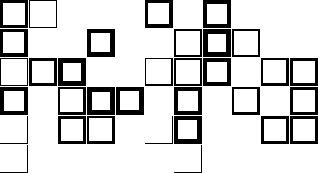

[     559 Epoch:[ 0/25] [ 159/1093] time: 54.0584, d_loss: 1.48331094, g_loss: 2.20645452, walk_loss: 2.20645452
Target image:


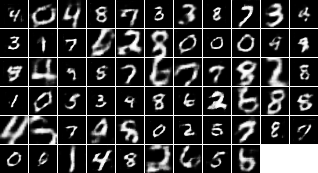

Target mask:


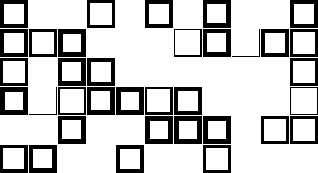

[     560 Epoch:[ 0/25] [ 160/1093] time: 54.3584, d_loss: 1.51044464, g_loss: 2.19338632, walk_loss: 2.19338632
Target image:


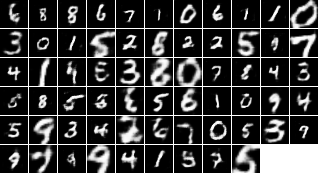

Target mask:


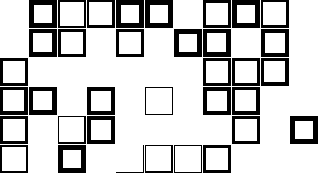

[     561 Epoch:[ 0/25] [ 161/1093] time: 54.6623, d_loss: 1.49857342, g_loss: 2.20661163, walk_loss: 2.20661187
Target image:


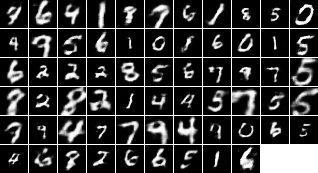

Target mask:


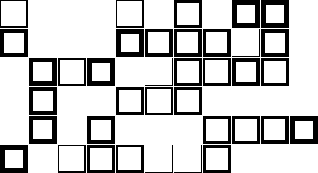

[     562 Epoch:[ 0/25] [ 162/1093] time: 54.9658, d_loss: 1.50776899, g_loss: 2.19453073, walk_loss: 2.19453096
Target image:


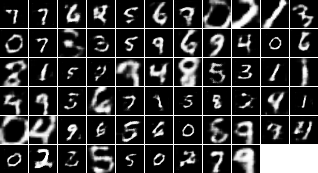

Target mask:


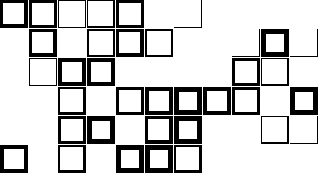

[     563 Epoch:[ 0/25] [ 163/1093] time: 55.2656, d_loss: 1.49812031, g_loss: 2.21548295, walk_loss: 2.21548295
Target image:


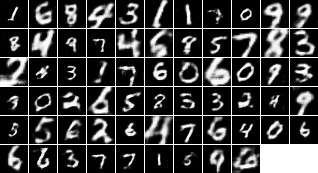

Target mask:


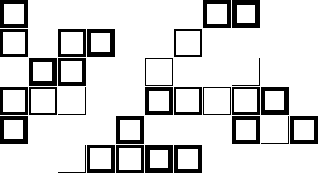

[     564 Epoch:[ 0/25] [ 164/1093] time: 55.5582, d_loss: 1.50333595, g_loss: 2.20930004, walk_loss: 2.20930004
Target image:


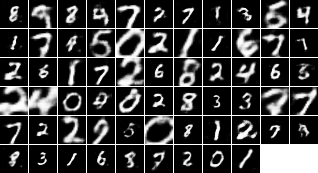

Target mask:


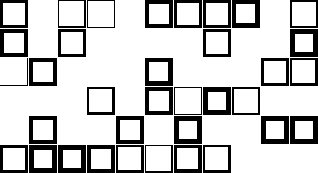

[     565 Epoch:[ 0/25] [ 165/1093] time: 55.8280, d_loss: 1.49877214, g_loss: 2.23643327, walk_loss: 2.23643279
Target image:


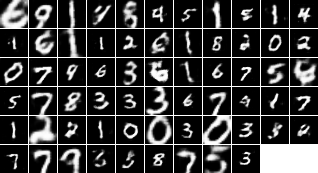

Target mask:


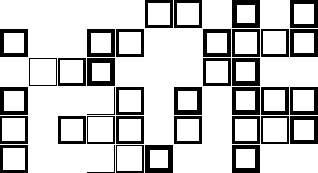

[     566 Epoch:[ 0/25] [ 166/1093] time: 56.1287, d_loss: 1.49778771, g_loss: 2.20821214, walk_loss: 2.20821214
Target image:


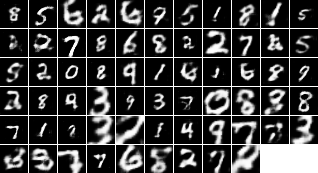

Target mask:


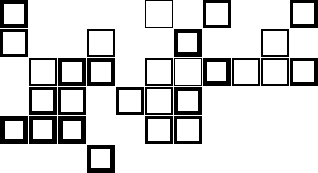

[     567 Epoch:[ 0/25] [ 167/1093] time: 56.4228, d_loss: 1.49258542, g_loss: 2.20194411, walk_loss: 2.20194411
Target image:


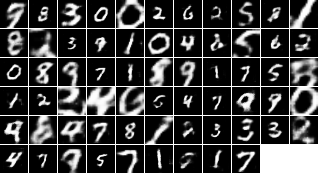

Target mask:


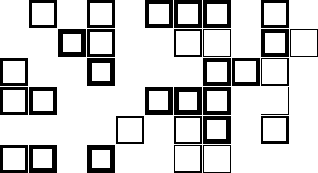

[     568 Epoch:[ 0/25] [ 168/1093] time: 56.7085, d_loss: 1.48679316, g_loss: 2.21494460, walk_loss: 2.21494460
Target image:


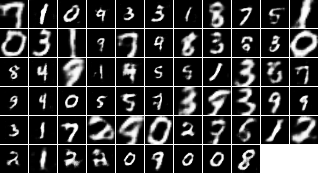

Target mask:


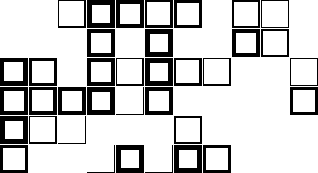

[     569 Epoch:[ 0/25] [ 169/1093] time: 57.0003, d_loss: 1.48602879, g_loss: 2.22746825, walk_loss: 2.22746825
Target image:


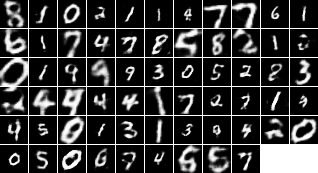

Target mask:


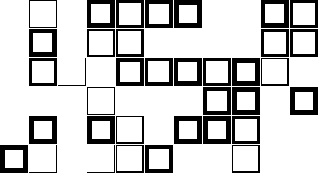

[     570 Epoch:[ 0/25] [ 170/1093] time: 57.2530, d_loss: 1.48920321, g_loss: 2.20929146, walk_loss: 2.20929146
Target image:


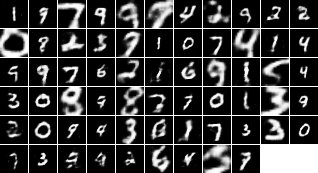

Target mask:


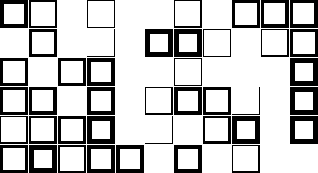

[     571 Epoch:[ 0/25] [ 171/1093] time: 57.5388, d_loss: 1.48446262, g_loss: 2.22650075, walk_loss: 2.22650075
Target image:


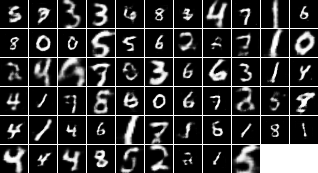

Target mask:


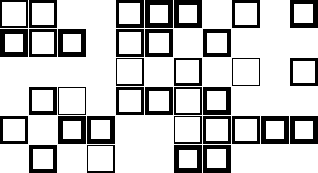

[     572 Epoch:[ 0/25] [ 172/1093] time: 57.8305, d_loss: 1.49664128, g_loss: 2.17737293, walk_loss: 2.17737293
Target image:


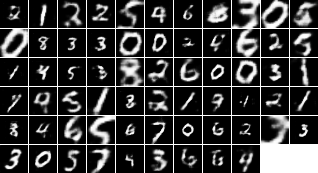

Target mask:


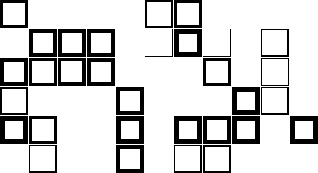

[     573 Epoch:[ 0/25] [ 173/1093] time: 58.0986, d_loss: 1.47918546, g_loss: 2.23094535, walk_loss: 2.23094535
Target image:


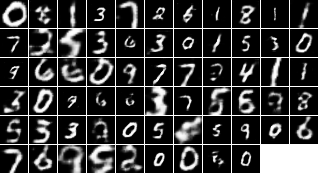

Target mask:


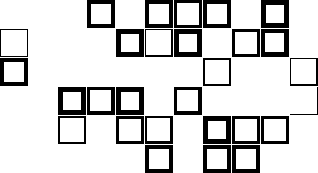

[     574 Epoch:[ 0/25] [ 174/1093] time: 58.3927, d_loss: 1.49766874, g_loss: 2.24216104, walk_loss: 2.24216104
Target image:


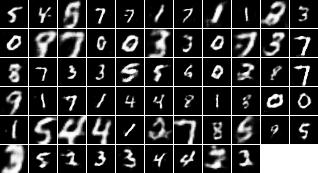

Target mask:


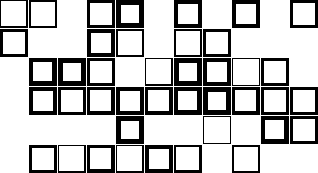

[     575 Epoch:[ 0/25] [ 175/1093] time: 58.6589, d_loss: 1.50142038, g_loss: 2.22412586, walk_loss: 2.22412586
Target image:


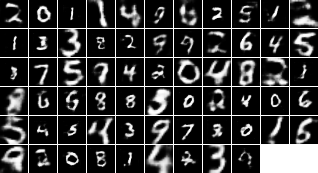

Target mask:


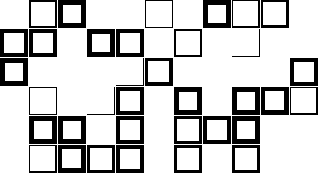

[     576 Epoch:[ 0/25] [ 176/1093] time: 58.9237, d_loss: 1.49470174, g_loss: 2.21332765, walk_loss: 2.21332765
Target image:


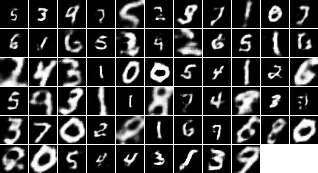

Target mask:


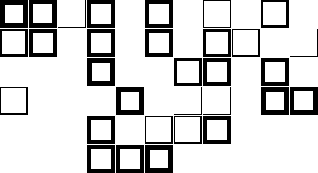

[     577 Epoch:[ 0/25] [ 177/1093] time: 59.1921, d_loss: 1.49018586, g_loss: 2.21815419, walk_loss: 2.21815419
Target image:


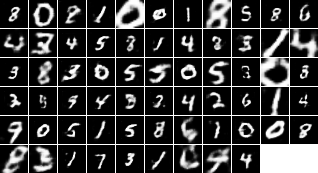

Target mask:


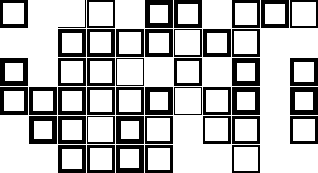

[     578 Epoch:[ 0/25] [ 178/1093] time: 59.4494, d_loss: 1.48482609, g_loss: 2.23070550, walk_loss: 2.23070550
Target image:


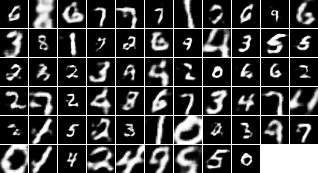

Target mask:


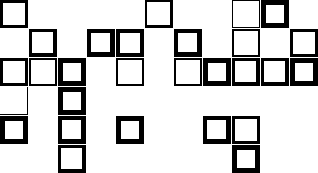

[     579 Epoch:[ 0/25] [ 179/1093] time: 59.7071, d_loss: 1.49662340, g_loss: 2.17661285, walk_loss: 2.17661285
Target image:


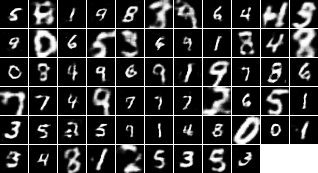

Target mask:


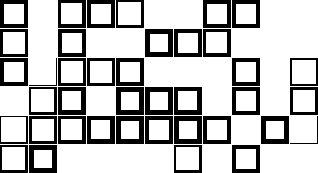

[     580 Epoch:[ 0/25] [ 180/1093] time: 59.9822, d_loss: 1.49476385, g_loss: 2.21386361, walk_loss: 2.21386361
Target image:


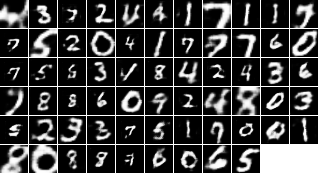

Target mask:


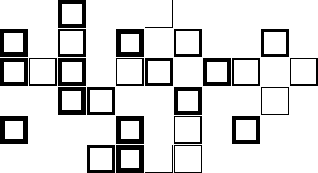

[     581 Epoch:[ 0/25] [ 181/1093] time: 60.2290, d_loss: 1.50235713, g_loss: 2.20654202, walk_loss: 2.20654202
Target image:


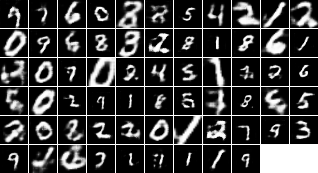

Target mask:


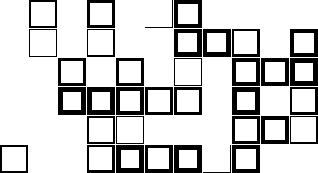

[     582 Epoch:[ 0/25] [ 182/1093] time: 60.4941, d_loss: 1.49558091, g_loss: 2.21244836, walk_loss: 2.21244836
Target image:


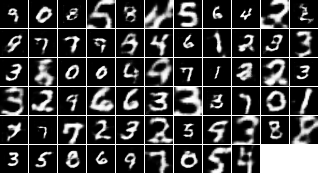

Target mask:


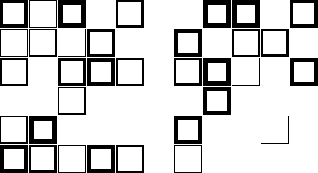

[     583 Epoch:[ 0/25] [ 183/1093] time: 60.7897, d_loss: 1.49671865, g_loss: 2.23902225, walk_loss: 2.23902225
Target image:


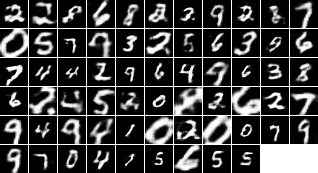

Target mask:


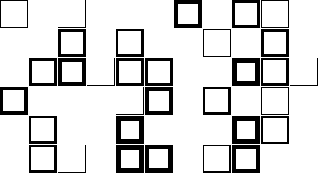

[     584 Epoch:[ 0/25] [ 184/1093] time: 61.0791, d_loss: 1.48980725, g_loss: 2.22420788, walk_loss: 2.22420812
Target image:


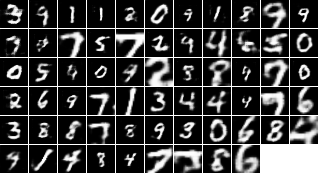

Target mask:


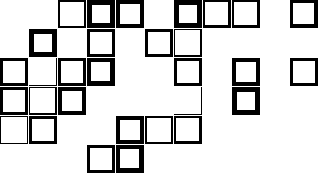

[     585 Epoch:[ 0/25] [ 185/1093] time: 61.3426, d_loss: 1.49321854, g_loss: 2.22407436, walk_loss: 2.22407436
Target image:


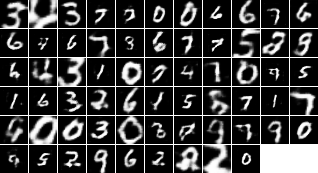

Target mask:


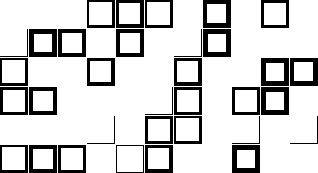

[     586 Epoch:[ 0/25] [ 186/1093] time: 61.5871, d_loss: 1.50179565, g_loss: 2.22536445, walk_loss: 2.22536469
Target image:


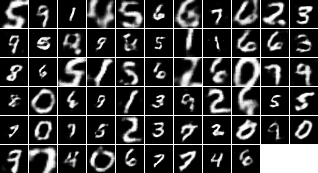

Target mask:


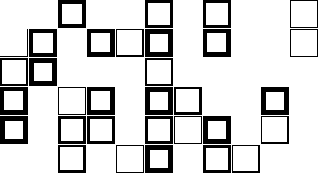

[     587 Epoch:[ 0/25] [ 187/1093] time: 61.8241, d_loss: 1.49238288, g_loss: 2.21579361, walk_loss: 2.21579361
Target image:


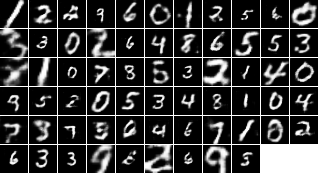

Target mask:


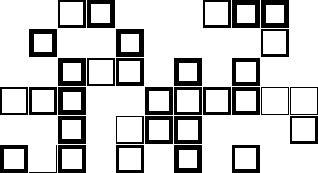

[     588 Epoch:[ 0/25] [ 188/1093] time: 62.0689, d_loss: 1.48454070, g_loss: 2.20849347, walk_loss: 2.20849347
Target image:


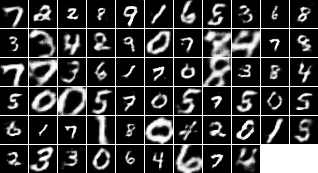

Target mask:


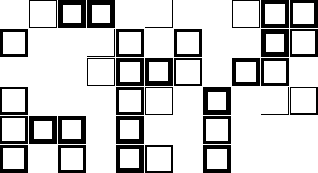

[     589 Epoch:[ 0/25] [ 189/1093] time: 62.3061, d_loss: 1.50320077, g_loss: 2.21074414, walk_loss: 2.21074438
Target image:


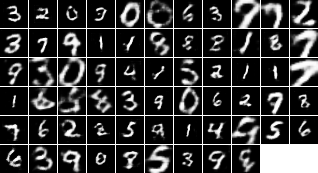

Target mask:


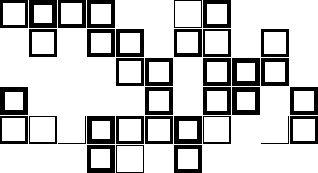

[     590 Epoch:[ 0/25] [ 190/1093] time: 62.5550, d_loss: 1.48146629, g_loss: 2.22151661, walk_loss: 2.22151661
Target image:


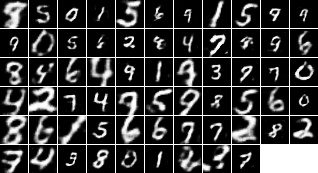

Target mask:


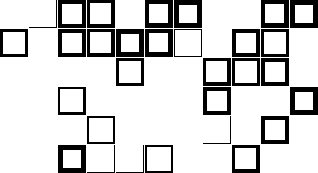

[     591 Epoch:[ 0/25] [ 191/1093] time: 62.7961, d_loss: 1.49458349, g_loss: 2.21406245, walk_loss: 2.21406245
Target image:


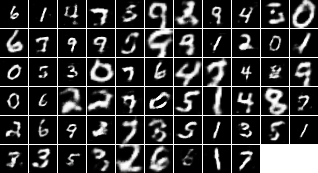

Target mask:


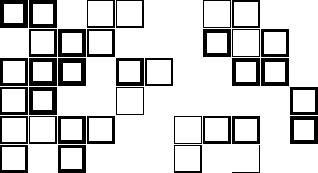

[     592 Epoch:[ 0/25] [ 192/1093] time: 63.0833, d_loss: 1.50042403, g_loss: 2.20587635, walk_loss: 2.20587635
Target image:


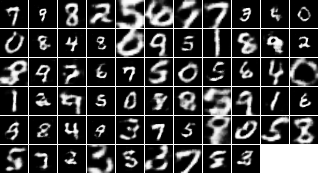

Target mask:


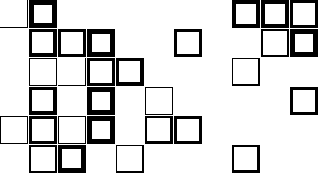

[     593 Epoch:[ 0/25] [ 193/1093] time: 63.3782, d_loss: 1.50046837, g_loss: 2.21315098, walk_loss: 2.21315098
Target image:


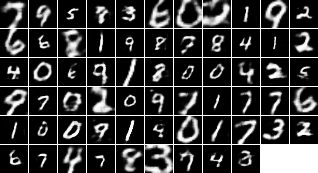

Target mask:


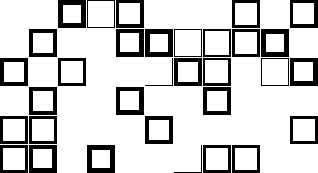

[     594 Epoch:[ 0/25] [ 194/1093] time: 63.6698, d_loss: 1.49602866, g_loss: 2.20350695, walk_loss: 2.20350695
Target image:


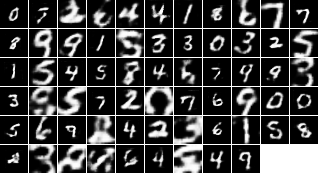

Target mask:


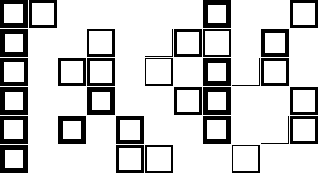

In [ ]:
tf.app.run(argv=['--dataset', 'mnist', '--input_height=28', '--output_height=28', '--train', '--out_name=ckpt'])

In [ ]:
# !tensorboard --logdir ./out/ckpt/logs